# Analysis and Figures

Analysis of simulation results and exprimental data presented in:

Shevtosva NA, Lockhart AB, Rybak IA, Magnuson DSK, Danner SM. **Reorganization of spinal neural connectivity following recovery after thoracic spinal cord injury: insights from computational modelling.** *bioRxiv*, 2025.05.17.654682; doi: [10.1101/2025.05.17.654682](https://doi.org/10.1101/2025.05.17.654682)

Copyright (c) 2025 The Authors. Licensed under [GNU GPL v3](https://www.gnu.org/licenses/gpl-3.0).

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:  # noqa: E722
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/dannerlab/rat-sci-locomotion-model
    %cd rat-sci-locomotion-model

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import circmean, circstd
import seaborn as sns
sns.set_theme(style="white", color_codes=True)
import scipy.stats as scstats
from sklearn.preprocessing import normalize
import networkx as nx
from copy import deepcopy
import warnings
from classify_gait import classify_gait

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

limb_names = ['lh', 'rh', 'lf', 'rf']
%matplotlib inline

fc = ['#000000','#F7941D','#00A875','#0072BC','#DA70D6']
mpl.rcParams['figure.dpi']= 300
sns.set_context("paper")


sns.set(font='serif')
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["lines.linewidth"]= 1
plt.rcParams["pdf.fonttype"]= 42
plt.rcParams["ps.fonttype"]= 42
sns.set(font_scale=0.5)


sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'

colormap = np.array([[0, 0, 0],  # black
                [230, 159, 0],  # orange
                [86, 180, 233],  # sky blue
                [0, 158, 115],  # bluish green
                [240, 228, 66],  # yellow
                [0, 114, 178],  # blue
                [213, 94, 0],  # vermillion
                [204, 121, 167], # reddish purple
                [255, 255, 255]],dtype=float)/255. 

In [2]:
intact_fn = './data/df_intact_sim_8s_final.h5'
hemi_fn = './data/df_hemi_sim_8s_final.h5'
contusion_fn = './data/df_contusion_sim_8s_final.h5'

df_intact = pd.read_hdf(intact_fn, key='df')
df_intact_raw = pd.read_hdf(intact_fn, key='df_raw')

df_hemi = pd.read_hdf(hemi_fn, key='df')
df_hemi_raw = pd.read_hdf(hemi_fn, key='df_raw')

df_contusion = pd.read_hdf(contusion_fn, key='df')
df_contusion_raw = pd.read_hdf(contusion_fn, key='df_raw')

df_hemi['SCI']='hemisection'
df_intact['SCI']='intact'
df_contusion['SCI']='contusion'
df_hemi_raw['SCI']='hemisection'
df_intact_raw['SCI']='intact'
df_contusion_raw['SCI']='contusion'

ramp_duration = 8.

for i,df in enumerate([ df_intact,df_hemi, df_contusion]):
    df['bout'] = np.floor(np.array(df.index) / 10).astype(int)
    df['bout'] = np.floor((df.ro-ramp_duration)/(2*ramp_duration)).astype(int)
    df["RID"] = 0
    df["ID"] = i

df_phases_simulation = pd.concat([df_hemi, df_intact, df_contusion], axis=0)
df_phases_simulation.reset_index(inplace=True, drop=True)


for i,df_ in enumerate([ df_intact_raw,df_hemi_raw, df_contusion_raw]):
    df_['bout'] = np.floor((df_.onset-ramp_duration)/(2*ramp_duration)).astype(int)
    df_["RID"] = 0
    df_["ID"] = i

df_raw_simulation = pd.concat([df_intact_raw, df_hemi_raw, df_contusion_raw], axis=0)
df_raw_simulation.reset_index(inplace=True, drop=True)


In [3]:
df_raw_data = pd.read_hdf("./data/df_raw.h5",key='df_raw')
df_phases_data = pd.read_hdf("./data/df_phases.h5",key='df_phases')

In [4]:
# Change the sequence of categories 
for df in [df_raw_data, df_phases_data, df_raw_simulation, df_phases_simulation]:
    df['SCI'] = pd.Categorical(df['SCI']).reorder_categories(['intact', 'hemisection', 'contusion'])

for df in [df_phases_data,  df_phases_simulation]:
    df = classify_gait(df)

In [5]:
def plot_barh_polar(ax,xranges,yranges,fc_,n=360):
    for xrange in xranges:
        xrange_ = [(x,1.01*2*np.pi/n) for x in np.arange(xrange[0],xrange[0]+xrange[1],2*np.pi/n)]
        ax.broken_barh(xrange_,yranges,facecolors=fc_,edgecolors=None,linewidths=0)

def circ_r(a,low=0,high=1):
    a=(a-low)*2*np.pi/(high-low)
    return np.abs(np.sum(np.exp(1j*a)))/len(a)

def plot_avg_gait_stance(df,label,ax):
    df = df[['LR_h','hl','diag','duty_factor_lh','duty_factor_rh','duty_factor_rf','duty_factor_lf','frequency','phase_dur']].dropna()

    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    duty_factor = [np.mean(df.duty_factor_lh),
                   np.mean(df.duty_factor_rh),
                   np.mean(df.duty_factor_lf),
                   np.mean(df.duty_factor_rf)]
    frequency = np.mean(df.frequency)
    
    phases=[0.0,lr,hl,diag]
    phases_sd=[0.0,circstd(df.LR_h,1,0),circstd(df.hl,1,0),circstd(df.diag,1,0)]
    print("{:10s}\tLR={:1.3f}+-{:1.3f}, HL={:1.3f}+-{:1.3f}, diag={:1.3f}+-{:1.3f}".format(\
        label,phases[1],phases_sd[1],phases[2],phases_sd[2],phases[3],phases_sd[3]))
    period = 1/frequency
    width = 0.2
    
    for j in range(4):
        scale = np.mean(df.phase_dur)
        xranges = [[phases[j]*scale,duty_factor[j]*scale],[phases[j]*scale-scale,duty_factor[j]*scale]]
        xranges = [[x[0],x[1]] if ((x[1]+x[0])<scale) else [x[0],scale-x[0]] for x in xranges]
        yranges = (1.0+j*width*1.5,width)
        ax.broken_barh(xranges,yranges,facecolors=fc[j],lw=0)
        xranges = [[phases[j]*scale-phases_sd[j]*scale,phases_sd[j]*scale],[phases[j]*scale+duty_factor[j]*scale,phases_sd[j]*scale]]
        xranges = [[x[0],x[1]] if (x[0]<scale) else [x[0]-scale,x[1]] for x in xranges]
        yranges = (1.0+j*width*1.5+0.45*width,width*0.1)
        #ax.broken_barh(xranges,yranges,facecolors=fc[j],lw=0)
        for xr in xranges:
            ax.plot([xr[0],xr[0]+xr[1]],[1.0+j*width*1.5+0.5*width]*2,lw=1,c=fc[j])
    ax.axvline(x=scale,c='k',lw=0.5)
    ax.axvline(x=0,c='k',lw=0.5)
    ax.set_xlim((0,0.31))
    ax.set_yticks([1.0+j*width*1.5+width*0.5 for j in range(4)])
    ax.set_yticklabels(['lh','rh','lf','rf'])
    ax.set_title(str(label) +' '+ str(len(df)))

def plot_avg_gait_phase(df,label,ax):
    df = df[['LR_h','LR_f','hl','diag','duty_factor_lh','duty_factor_rh','duty_factor_rf','duty_factor_lf','frequency','phase_dur']].dropna()
    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    lr_fl = circmean(df.LR_f,1,0)
    duty_factor = [np.mean(df.duty_factor_lh),
                   np.mean(df.duty_factor_rh),
                   np.mean(df.duty_factor_lf),
                   np.mean(df.duty_factor_rf)]
    frequency = np.mean(df.frequency)
    phases=np.array([0.0,lr,hl,diag,lr_fl])
    phase_r=np.array([1.0,circ_r(df.LR_h),circ_r(df.hl),circ_r(df.diag),circ_r(df.LR_f)])
    
    period = 1/frequency
    width = 0.3
    
    for j in range(len(phase_r)):        
        ax.plot([phases[j]*2*np.pi]*2,[0,phase_r[j]],fc[j])
    ax.scatter(phases*2*np.pi,phase_r,c=fc)
    ax.set_ylim((0,1.1))
    ax.set_yticks([1])
    ax.set_yticklabels([""])
        
    
    #for ax_ in ax:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
        
    ax.set_title(str(label) )
    ax.set_thetagrids(
                np.linspace(0.0, 360, 9)[:-1], ["0", "", ".25", "", ".5", "", ".75",""],
                fontsize=10)
    
def plot_avg_footp(df,label,ax):
    x=df[['x_stance_lh','x_stance_rh','x_stance_lf','x_stance_rf']].values
    y=df[['y_stance_lh','y_stance_rh','y_stance_lf','y_stance_rf']].values
    sw=df[['step_width_x_lh','step_width_x_rh','step_width_x_lf','step_width_x_rf']].values
    ne=np.concatenate((np.diff(df.index.values)==1,[False]))
    x=x[ne,:]
    y=y[ne,:]
    sw=sw[ne,:]

    sw2=np.sum(np.sign(sw),1)
    y[sw2<0.0]=y[sw2<0.0]*-1.0
    x[sw2<0.0]=x[sw2<0.0]*-1.0
    sw[sw2<0.0]=sw[sw2<0.0]*-1.0
    
    x=x-np.nanmean(x,axis=1,keepdims=True)
    x=(x.transpose()-np.nanmedian(x[:,0])).transpose()
    y=y-np.nanmean(y,axis=1,keepdims=True)
    y=(y.transpose()-np.nanmedian(y[:,0])).transpose()
    
    ax.set_xlim([-7.5,35])
    ax.set_ylim([-6.5,1.5])
    ax.set_aspect('equal')
    
    for i in range(4):
        ax.scatter(np.nanmedian(x[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],lw=0)
        ax.scatter(np.nanmedian(x[:,i]+sw[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],alpha=0.25,lw=0)
        ax.scatter(np.nanmedian(x[:,i]-sw[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],alpha=0.25,lw=0)
        
    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    ph = [['lh',0,0],['rh',lr,1],['lf',hl,2],['rf',diag,3]]
    ph = sorted(ph,key=lambda x: x[1])
    #print(ph)
    ax.set_title(str(label))
    j=1
    for i in range(0,4): 
        if i>0:
            if (ph[i][1]-ph[i-1][1])<0.1:
                j=j-1
        ax.text(np.nanmedian(x[:,ph[i][2]]),np.nanmedian(y[:,ph[i][2]])-0.5,str(j),horizontalalignment='center',verticalalignment='top')
        j=j+1


def plot_gait_properties(df_phases,group,gaits,gait_var='gaits_all2'):
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(len(gaits)*3, 4, forward=True)
    gs = gridspec.GridSpec( 3,len(gaits), figure=fig)

    plt.tight_layout()
    for i,gait_ in enumerate(gaits):
        df_=df_phases[(df_phases.SCI==group)&(df_phases[gait_var]==gait_)]
        if len(df_)>10:
            label=gait_
            ax=[]
            ax.append( fig.add_subplot(gs[0, i]))
            #ax.append( fig.add_subplot(gs[1, i]))
            ax.append( fig.add_subplot(gs[2, i],projection='polar'))

            plot_avg_gait_stance(df_,label,ax[0])
            
            plot_avg_gait_phase(df_,"",ax[1])
            
            if label in 'bound':
                # if LR_h > 0. and < 0.5 the position of the right hind foot can be of the next step and cause problems in the average
                df_=df_[(df_.LR_h>0.5)]
            if label in 'trot':
                df_=df_[(df_.diag>0.5)]
                
            
            
            sns.despine(ax=ax[0],offset=5,trim=True)
            

    return fig

# Figure 3: Gait expression of pre-injury model and rats
## Fig 3B1: Pre-injury model

trot      	LR=0.496+-0.073, HL=0.510+-0.041, diag=0.017+-0.053
canter_2  	LR=0.244+-0.056, HL=0.326+-0.044, diag=0.773+-0.078
trans_1   	LR=0.757+-0.074, HL=0.571+-0.046, diag=0.201+-0.078
trans_2   	LR=0.217+-0.073, HL=0.457+-0.051, diag=0.806+-0.067
hbound    	LR=0.086+-0.036, HL=0.392+-0.058, diag=0.655+-0.064
hbound_2  	LR=0.922+-0.053, HL=0.615+-0.046, diag=0.339+-0.064
bound     	LR=0.012+-0.067, HL=0.514+-0.073, diag=0.514+-0.092


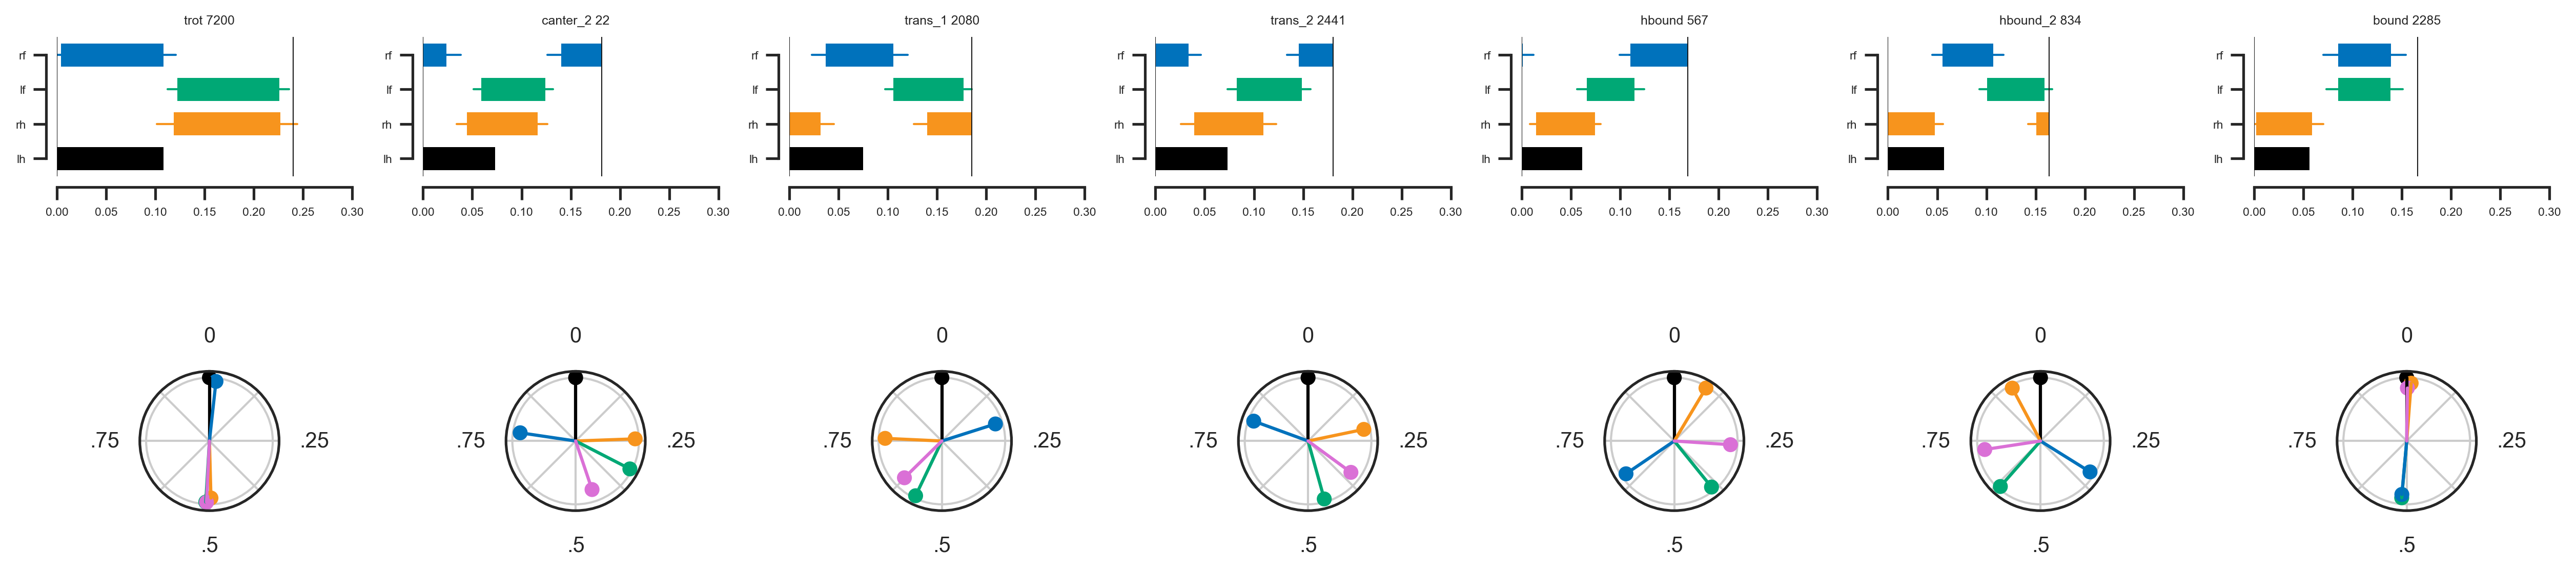

In [6]:
fig = plot_gait_properties(df_phases_simulation,'intact', ['trot','canter_2','trans_1','trans_2','hbound','hbound_2','bound'])

## Fig 3B2: Pre-injury rats

trot      	LR=0.488+-0.060, HL=0.473+-0.046, diag=0.975+-0.070
canter_2  	LR=0.297+-0.083, HL=0.361+-0.041, diag=0.735+-0.048
trans_1   	LR=0.789+-0.073, HL=0.560+-0.037, diag=0.188+-0.062
trans_2   	LR=0.237+-0.093, HL=0.444+-0.045, diag=0.764+-0.059
hbound    	LR=0.078+-0.041, HL=0.391+-0.047, diag=0.660+-0.041
hbound_2  	LR=0.948+-0.043, HL=0.609+-0.043, diag=0.356+-0.058
bound     	LR=0.020+-0.035, HL=0.608+-0.092, diag=0.587+-0.093


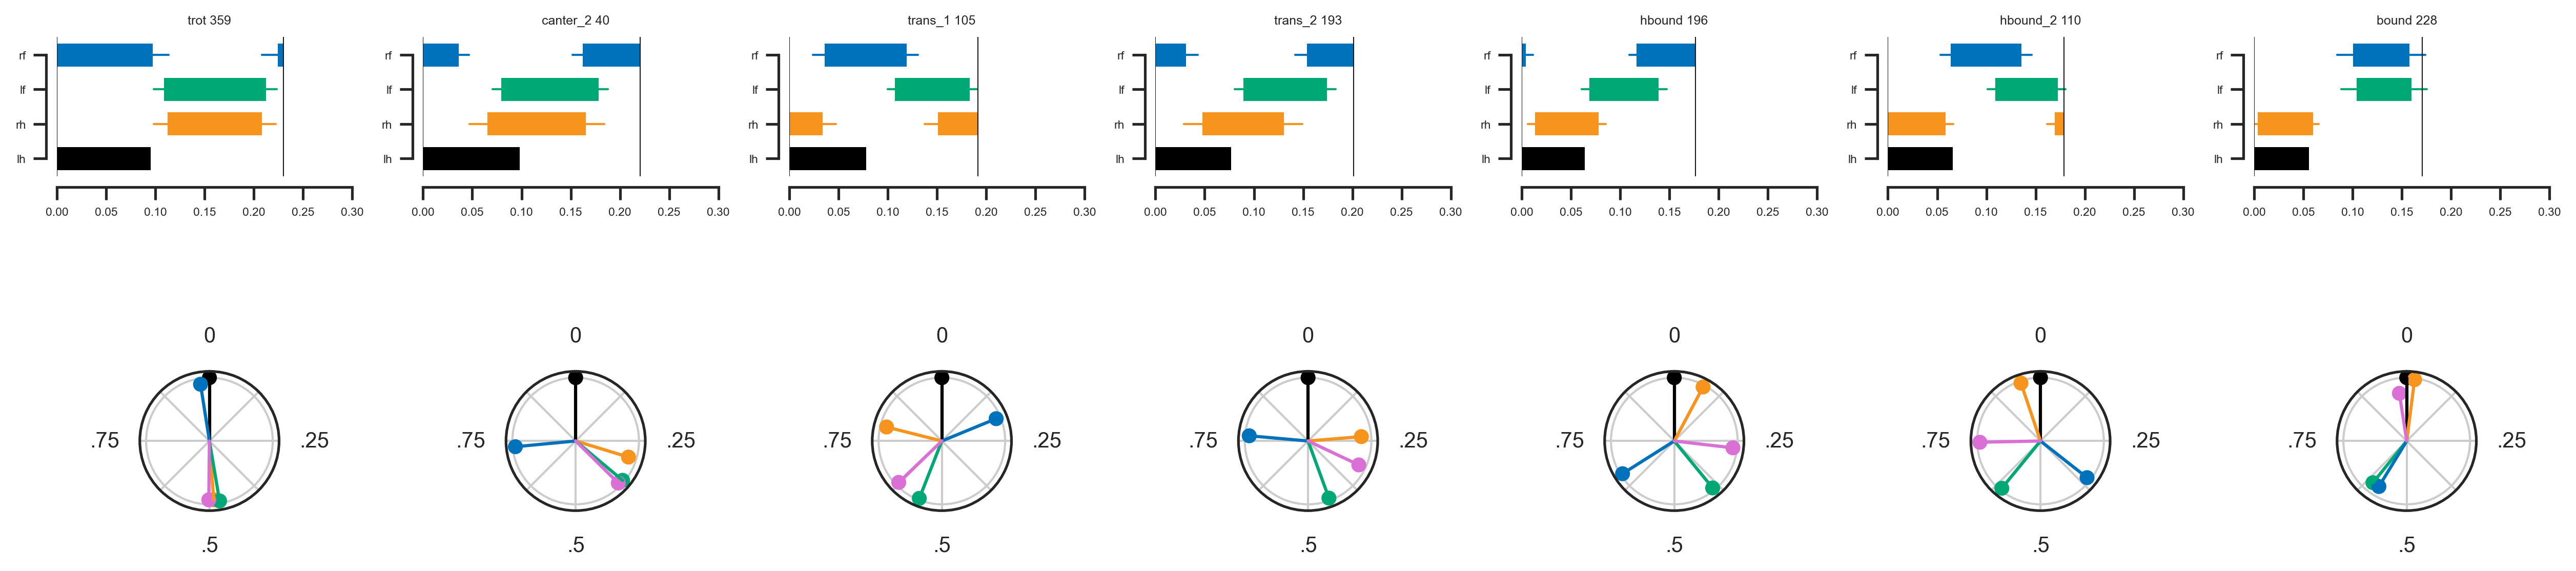

In [7]:
fig = plot_gait_properties(df_phases_data,'intact', ['trot','canter_2','trans_1','trans_2','hbound','hbound_2','bound'])

# Figure 4: Frequency-dependent distribution of normalized phase differences and phase durations in the model and in rats

In [8]:
def plot_phase_frequency_distribution(case = 'intact'):
    cp=sns.color_palette("Paired", 20)
    cp[0]=cp[11]
    cp.pop(7)
    abc=['1','2','3']
    x_col, x_lim, bw = ('frequency', (2.0, 8.0), (0.35, 0.05))
    N_rows = 9
    if case != 'intact':
        N_rows = 7
    fig, ax = plt.subplots(N_rows, 2, sharex='all', sharey='row')
    fig.set_size_inches(8.*2/3, 10*9/8, forward=True)

    df_p_data_ = df_phases_data[df_phases_data.SCI==case]
    df_p_sim_ = df_phases_simulation[df_phases_simulation.SCI==case]
    df_p_sim_sample = df_p_sim_.sample(n=len(df_p_data_))
    df_p_sim_sample = df_p_sim_sample.reset_index(drop=True)
    df_p_data_ = df_p_data_.reset_index(drop=True)


    gaits_for_violin ={'intact':['trot','gallop','hbound','bound'],
                       'hemisection':['trot','canter','gallop'],
                       'contusion':['nd','lat_seq','trot','diag_seq','pace']}
    
    gaits_ = gaits_for_violin[case]
    for (i, (df,name_)) in enumerate(zip([df_p_sim_sample, df_p_data_], ['simulation', 'data'])):
        #df_ = df[[x_col, phased,'gaits2']]
        df_ = df.dropna()
        col = [cp[k] for k in df_.gaits2.cat.codes.values]
        for (j, phased) in enumerate(['LR_h', 'LR_f', 'hl','hl_r', 'diag','diag_2']):
            ax[j, i].scatter(df_[x_col],df_[phased],c=col,alpha=0.5,s=2,lw=0)
            plt.setp(ax[j, i].artists, lw=1)#
            ax[j, i].plot(x_lim,[0.5,0.5],'k',lw=0.5,alpha=0.5)
            ax[j, i].plot(x_lim,[0.,0.],'k',lw=0.5,alpha=0.5)
            ax[j, i].plot(x_lim,[1,1],'k',lw=0.5,alpha=0.5)
            ax[j, i].set_xlim(x_lim)
            ax[j, i].set_ylim((-0.05, 1.05))
            ax[j, i].set_yticks([0,0.25,0.5,0.75,1.0])
            if j == 0:
                ax[j, i].set_title(abc[i]+" " +name_)
            if i == 0:
                ax[j, i].set_ylabel(phased)

        if case == 'intact':  
            for (j, (lab,st,sw)) in enumerate([('fl_ex_h','stance_dur_h','swing_dur_h'),('fl_ext_f','stance_dur_f','swing_dur_f')]):
                ax[j+7, i].scatter(df_[x_col],df_[st],c='b',alpha=0.25,s=2,lw=0)
                ax[j+7, i].scatter(df_[x_col],df_[sw],c='g',alpha=0.25,s=2,lw=0)
                ax[j+7, i].set_ylim((0.0, 0.2))
                if i == 0:
                    ax[j+7, i].set_ylabel(lab)

    for (i, (df,name_)) in enumerate(zip([df_p_sim_, df_p_data_], ['simulation', 'data'])):    
        df2_=df[df.gaits2.isin(gaits_)]
        sns.violinplot(data=df2_,x='frequency',y='gaits2',linewidth=0.25,palette=cp,density_norm='width',cut=0,common_norm=True,ax=ax[6,i]) 
        #ax[6, i].legend_.remove()
        ax[-1,i].set_xlabel('Frequency (Hz)') 
    sns.despine(offset=5,trim=True )

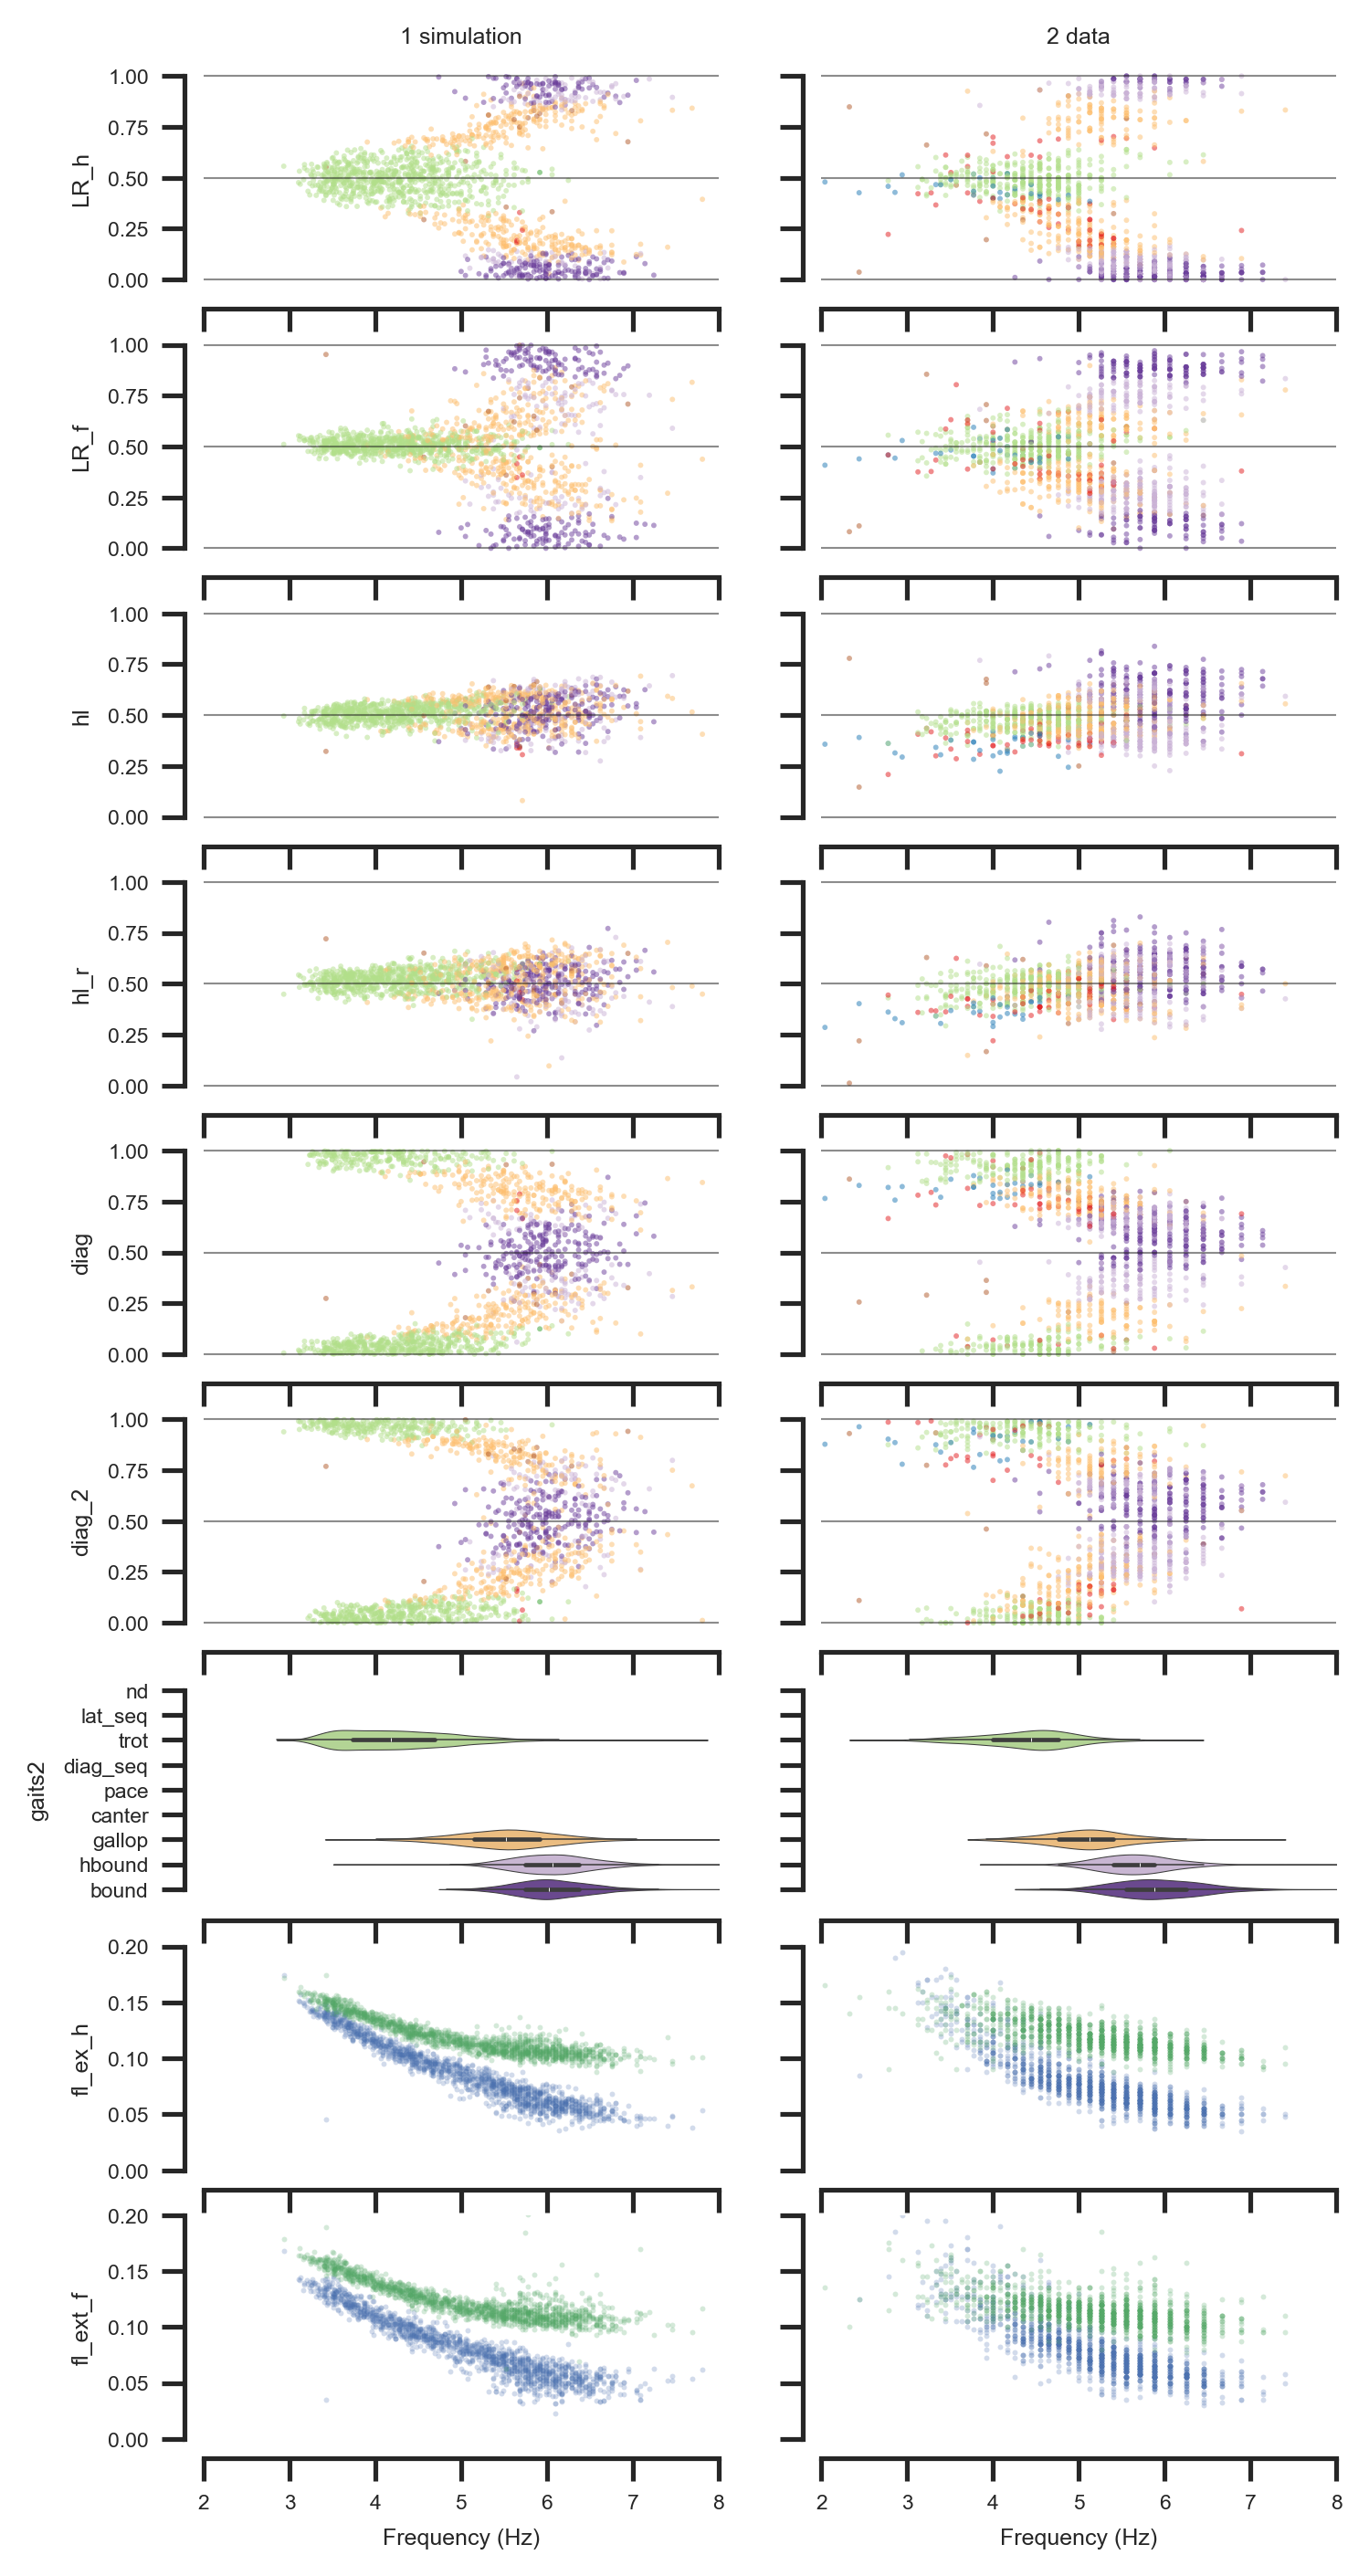

In [9]:
plot_phase_frequency_distribution('intact')

## Figure 5A: Gait prevalences

In [10]:
def plot_gait_prevalences(df_phases,ax,gait_var_='gaits2'):
    ct = pd.crosstab(df_phases[gait_var_], df_phases.SCI, normalize='columns')
    stacked = ct.stack().reset_index().rename(columns={0: 'value'})

    stacked.SCI = pd.Categorical(
        stacked.SCI,
        categories=["intact",  "hemisection", "contusion"],
        ordered=False)
    stacked = stacked.rename(index=str, columns={'value': 'occurance'})
    chi2, p, _,_ = scstats.chi2_contingency(pd.crosstab(df_phases[gait_var_], df_phases.SCI))
    print('Counts')
    print(pd.crosstab(df_phases[gait_var_], df_phases.SCI,margins=True))
    print('\nFractions (%)')
    print(pd.crosstab(df_phases[gait_var_], df_phases.SCI, normalize='columns').round(4)*100)

    cp=sns.color_palette("Paired", 20)
    cp[0]=cp[11]
    cp.pop(7)

    pivot_df = stacked.pivot(index='SCI', columns=gait_var_, values='occurance')
    pivot_df.plot.bar(ax=ax, stacked=True, color=cp, linewidth=0)
    sns.despine(offset=5,trim=True )
    print("\n\n")
    

1 Simulation
Counts
SCI       intact  hemisection  contusion    All
gaits2                                         
nd           153          265        571    989
lat_seq        0           11       2775   2786
trot        7201         8940       5445  21586
diag_seq       5            1       3491   3497
pace           0            1       1539   1540
canter        30          798        324   1152
gallop      4528         3573         52   8153
hbound      1401          446          2   1849
bound       2285          224          0   2509
All        15603        14259      14199  44061

Fractions (%)
SCI       intact  hemisection  contusion
gaits2                                  
nd          0.98         1.86       4.02
lat_seq     0.00         0.08      19.54
trot       46.15        62.70      38.35
diag_seq    0.03         0.01      24.59
pace        0.00         0.01      10.84
canter      0.19         5.60       2.28
gallop     29.02        25.06       0.37
hbound      8.98    

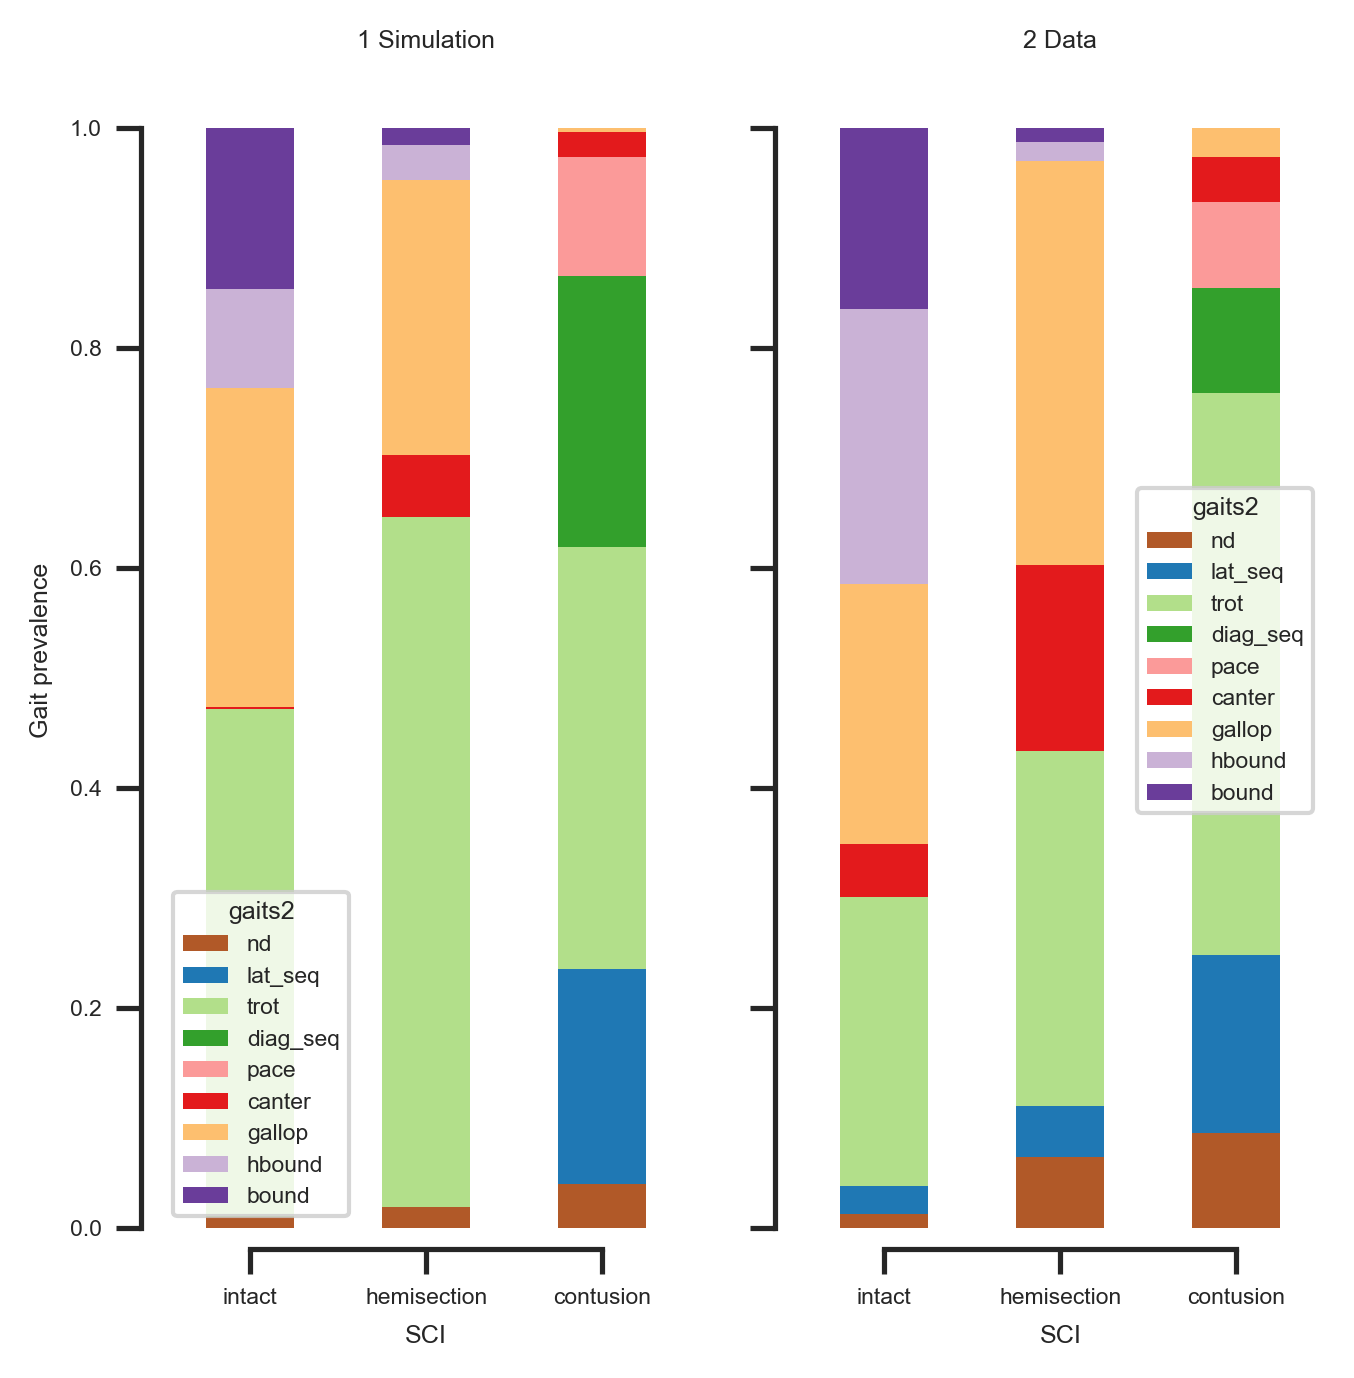

In [11]:
fig,ax = plt.subplots(1, 2, figsize=(5, 5), sharey='row')
print("1 Simulation")
plot_gait_prevalences(df_phases_simulation,ax[0])
print("2 Data")
plot_gait_prevalences(df_phases_data,ax[1])
ax[0].set_title('1 Simulation')
ax[1].set_title('2 Data')
ax[0].set_ylabel('Gait prevalence');
fig.savefig('gait_prevalence_sim_data.pdf', bbox_inches='tight', transparent=True)

## Figure 5C/D: Gait transition probabilities 

In [ ]:
def plot_gait_transition_graphs(df_phases):
    gait_cats = df_phases.gaits2.cat.categories
    N_gaits = len(df_phases.gaits2.cat.categories)
    group_cats = ["SCI"]

    gait_trans = []
    for group, df_ in df_phases.groupby(group_cats):
        row = {key: value for key, value in zip(group_cats,group)}
        
        T = np.zeros((N_gaits,N_gaits))
        gcodes = df_.gaits2.cat.codes.values
        for i in range(len(gcodes)-1):
            T[gcodes[i],gcodes[i+1]]+=1
        row['T']=T
        gait_trans.append(row)
        
    df_gait_t = pd.DataFrame(gait_trans)

    dfT=df_gait_t.groupby(['SCI']).apply(lambda x:np.sum(x['T']))


    def plot_graph(A,sci):
        cp=sns.color_palette("Paired", 20)
        cp[0]=cp[11]
        cp.pop(7)
        cp_dict = {g:c for g,c in zip(gait_cats,cp)}
        w_thr=0.001

        mask=np.sum(A,axis=0)>0
        self_weights_ = np.sum(A,axis=0)/np.sum(A)
        self_weights = self_weights_[mask]

        T=A/np.sum(A)
        G = nx.DiGraph()
        for i,g in enumerate(gait_cats):
            if mask[i]:
                G.add_node(g)
        for e in np.transpose(T.nonzero()):
            if np.isnan(T[e[0],e[1]]):
                continue
            if mask[e[0]] & mask[e[1]]:
                G.add_edge(gait_cats[e[0]], gait_cats[e[1]], weight=T[e[0],e[1]])
                
        edge_labels = nx.get_edge_attributes(G, "weight")
        edge_labels = {k:"{:3.3}".format(v) for k,v in edge_labels.items() if v>w_thr}
        
        einc = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > w_thr if u!=v]
        cinc = [cp_dict[e[0]] for e in einc]
        
        if sci == 'intact':
            pos={g:np.array([i, 0]) for i,g in enumerate(['trot','gallop','hbound','bound'])}
        elif sci == 'hemisection':
            pos={g:np.array([i, 0]) for i,g in enumerate(['trot','canter','gallop'])}
        elif sci == 'contusion':
            pos={g:np.array([i, 0]) for i,g in enumerate(['nd','lat_seq','trot','diag_seq','pace'])}
            d_ = 1/np.sqrt(2)
            pos={g:np.array(c) for g,c in zip(['nd','lat_seq','trot','diag_seq','pace'],[[0,0],[-d_,0],[0,-d_],[d_,0],[0,d_]])}
        
        
        winc = np.array([d['weight'] for u,v,d in G.edges(data=True)  if d["weight"] > w_thr if u!=v])

        node_sizes = 5000*self_weights
        
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes,node_color=[c for m,c in zip(mask,cp) if m])
        nx.draw_networkx_labels(G, pos, font_size=16) 

        nx.draw_networkx_edges(G, pos,edgelist=einc, width=winc*60,arrows=True,arrowstyle="->",connectionstyle='arc3,rad=0.5',node_size=node_sizes,edge_color=cinc)

    def plot_matrix(A,sci,igm):
        cmaps={'intact':'Oranges','hemisection':'Blues','contusion':'Purples'}
        T=normalize(A,axis=1,norm='l1')
        T=T[igm,:][:,igm]
        T[np.isnan(T)]=0.
        ax=plt.gca()
        df_ = pd.DataFrame(T,columns=gait_cats[igm],index=gait_cats[igm])
        sns.heatmap(df_, vmin=0.0, vmax=1.0, cmap=cmaps[sci], ax=ax, annot=True, fmt=".2f")



    inc_gaits= {'intact':     ['trot','gallop','hbound','bound'],
                'hemisection': ['trot','canter','gallop'],
                'contusion': ['nd','lat_seq','trot','diag_seq','pace']}
    inc_gait_mask = {k:np.array([np.where(df_phases.gaits2.cat.categories==gait)[0][0] for gait in gaits]) for k,gaits in inc_gaits.items()}

    fig,axs = plt.subplots(1,3)
    fig.set_size_inches(12,3)

    for i,sci in enumerate(['intact','hemisection','contusion']):
        igm = inc_gait_mask[sci]
        mask=np.setdiff1d(np.arange(len(df_phases.gaits2.cat.categories)),igm)
        A=deepcopy(dfT[sci])
        A[mask,:]=0
        A[:,mask]=0

        plt.sca(axs[i])

        plot_matrix(A,sci,igm)
        axs[i].set_title(sci)
        axs[i].set_aspect('equal')
        

    fig2,axs = plt.subplots(1,3,sharex='all',sharey='all')
    fig2.set_size_inches(24,6)
    for i,sci in enumerate(['intact','hemisection','contusion']):
        igm = inc_gait_mask[sci]
        mask=np.setdiff1d(np.arange(len(df_phases.gaits2.cat.categories)),igm)
        A=deepcopy(dfT[sci])
        A[mask,:]=0
        A[:,mask]=0

        plt.sca(axs[i])
        plot_graph(A,sci)
        axs[i].set_title(sci)
        axs[i].set_aspect('equal')
    return fig,fig2

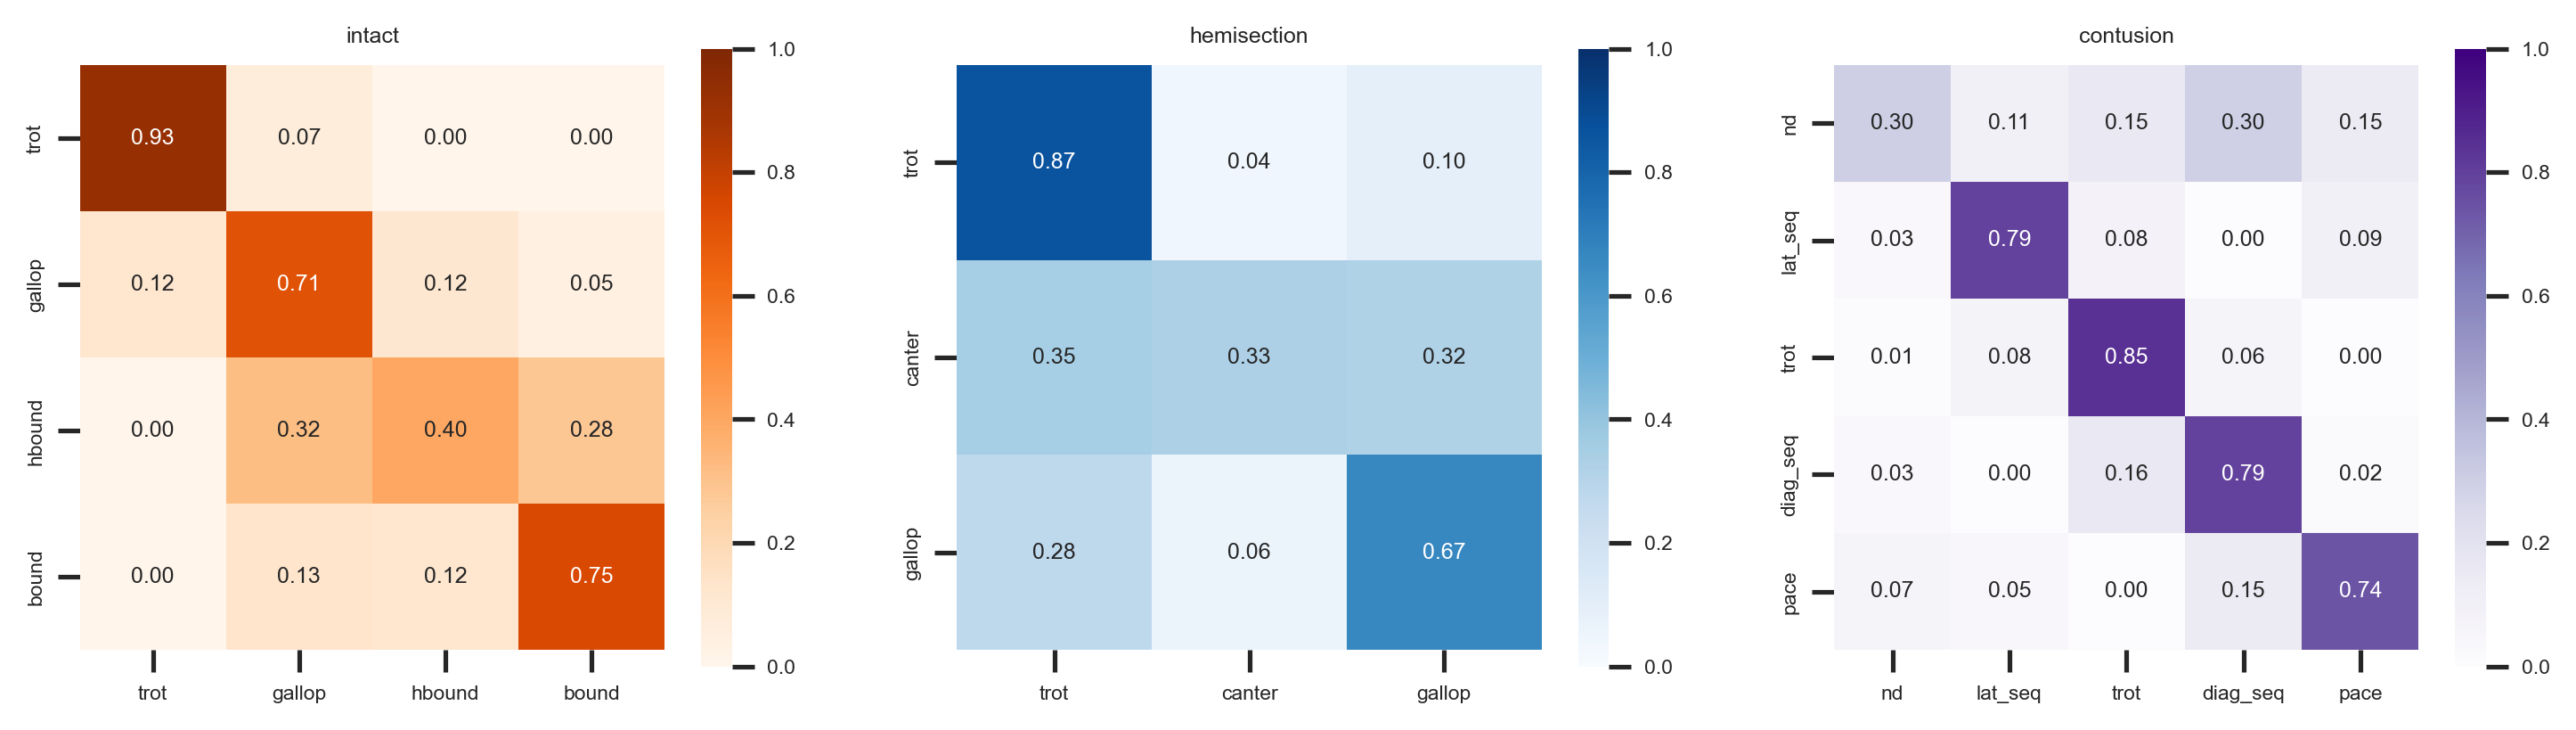

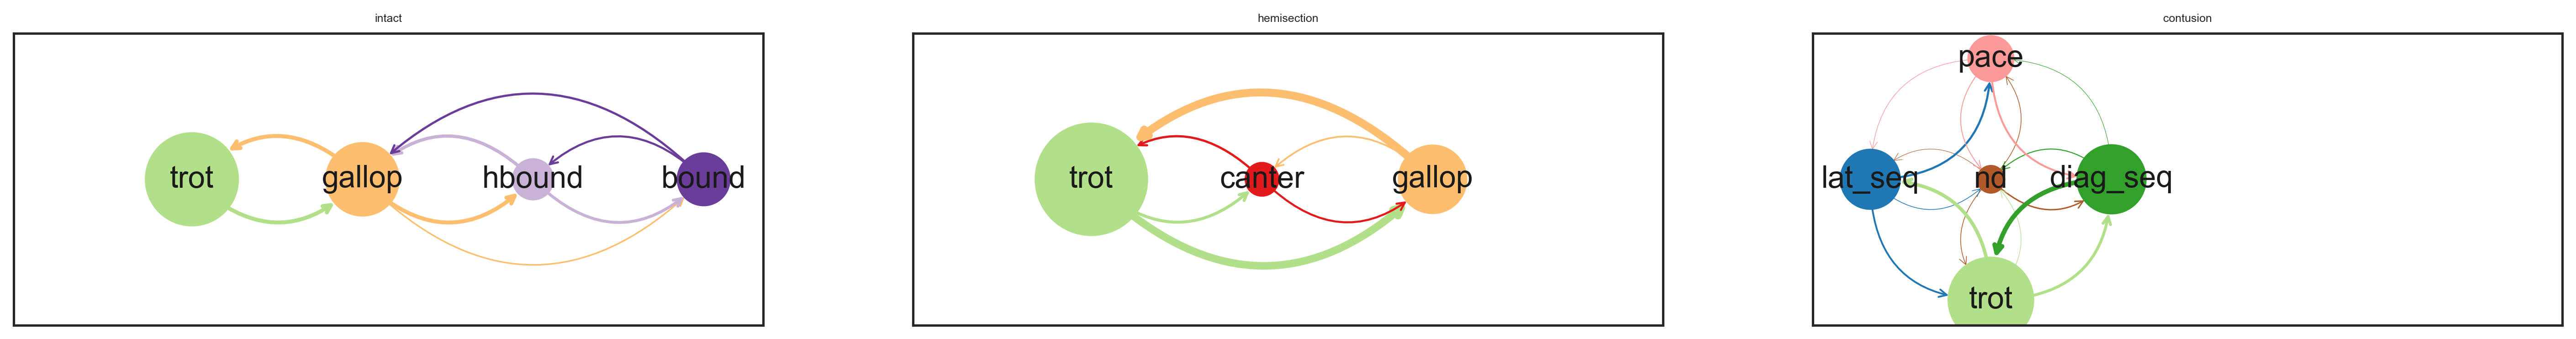

In [16]:
plot_gait_transition_graphs(df_phases_simulation)

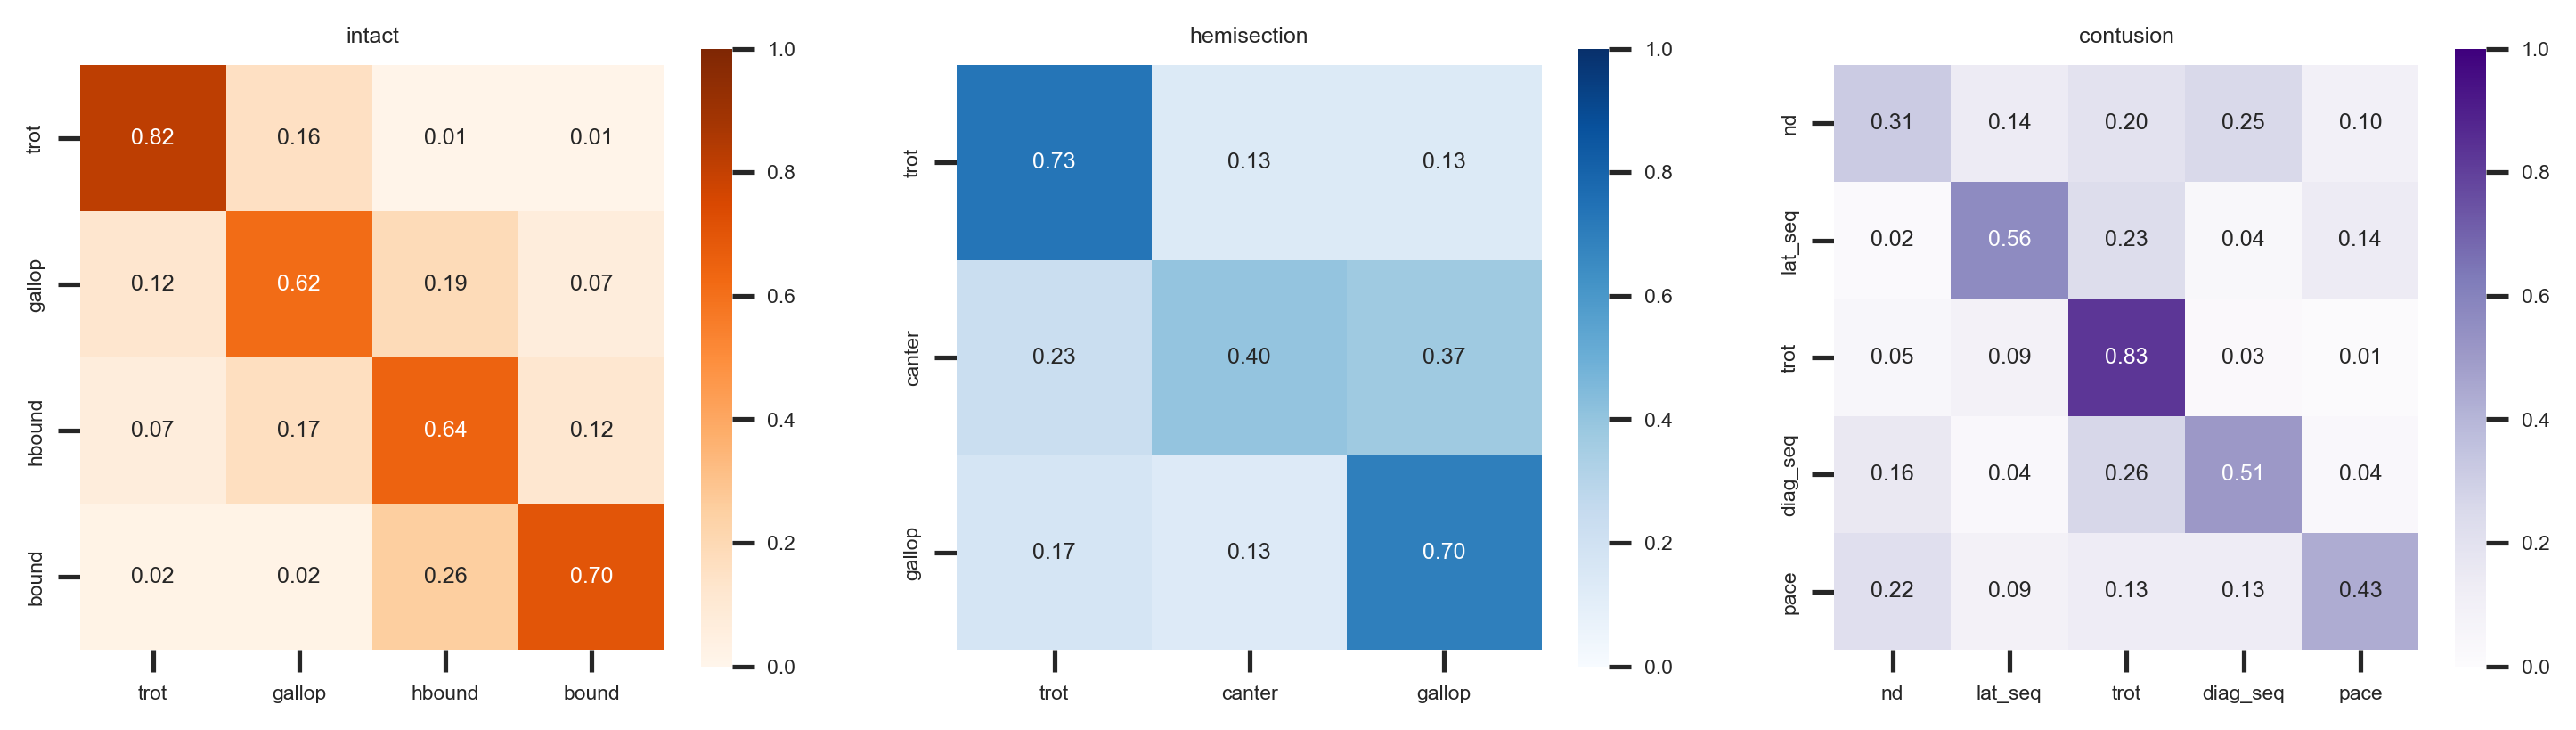

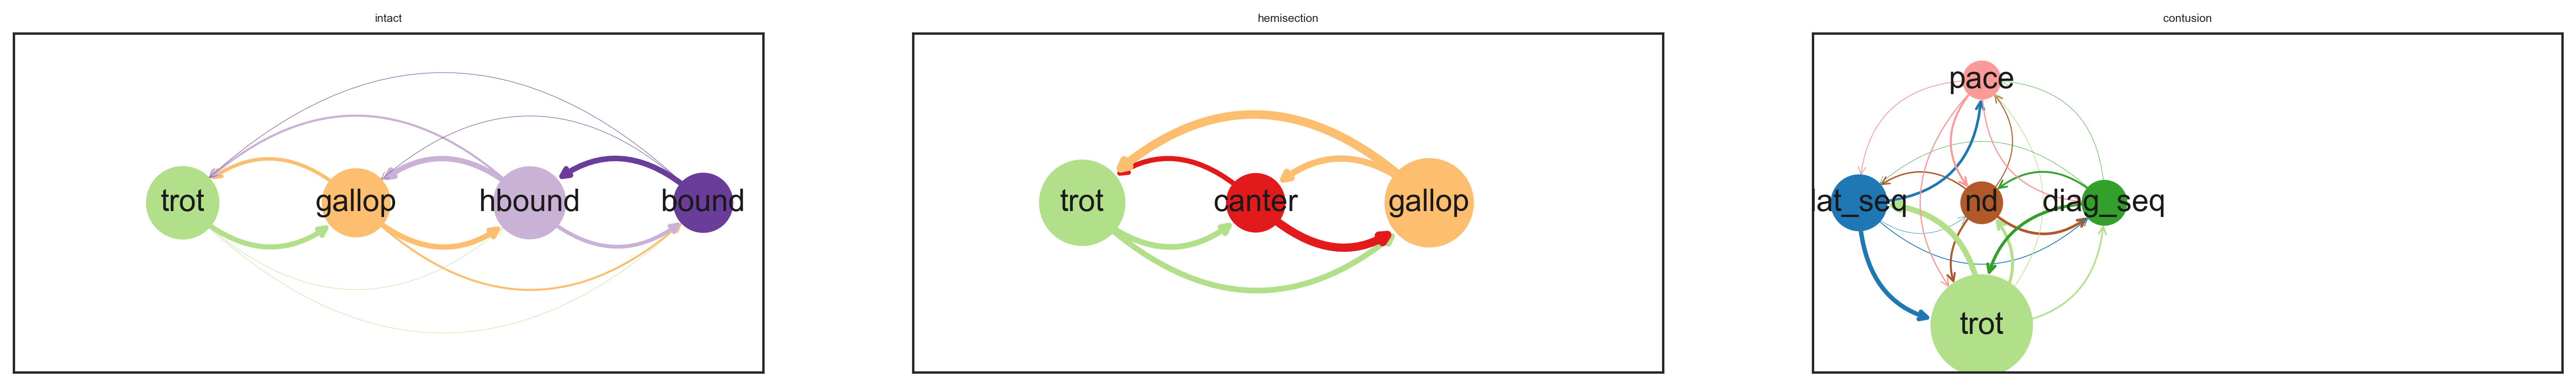

In [17]:
# gait transition graphs for data (not shown in the paper)
plot_gait_transition_graphs(df_phases_data)
plt.gcf().savefig('transitions_data.pdf', bbox_inches='tight', transparent=True)

            SCI  ID  RID  bout     pdiff     madev
0        intact   0    0    -1    r_LR_h  0.060180
1        intact   0    0     0    r_LR_h  0.072732
2        intact   0    0     1    r_LR_h  0.075750
3        intact   0    0     2    r_LR_h  0.066264
4        intact   0    0     3    r_LR_h  0.066229
...         ...  ..  ...   ...       ...       ...
3613  contusion   2    0   195  r_diag_2  0.075359
3614  contusion   2    0   196  r_diag_2  0.086886
3615  contusion   2    0   197  r_diag_2  0.094064
3616  contusion   2    0   198  r_diag_2  0.113764
3617  contusion   2    0   199  r_diag_2  0.086584

[3618 rows x 6 columns]
            SCI  ID  RID  bout     pdiff     madev
0        intact   0    0    -1    r_LR_h  0.060180
1        intact   0    0     0    r_LR_h  0.072732
2        intact   0    0     1    r_LR_h  0.075750
3        intact   0    0     2    r_LR_h  0.066264
4        intact   0    0     3    r_LR_h  0.066229
...         ...  ..  ...   ...       ...       ...
3613  

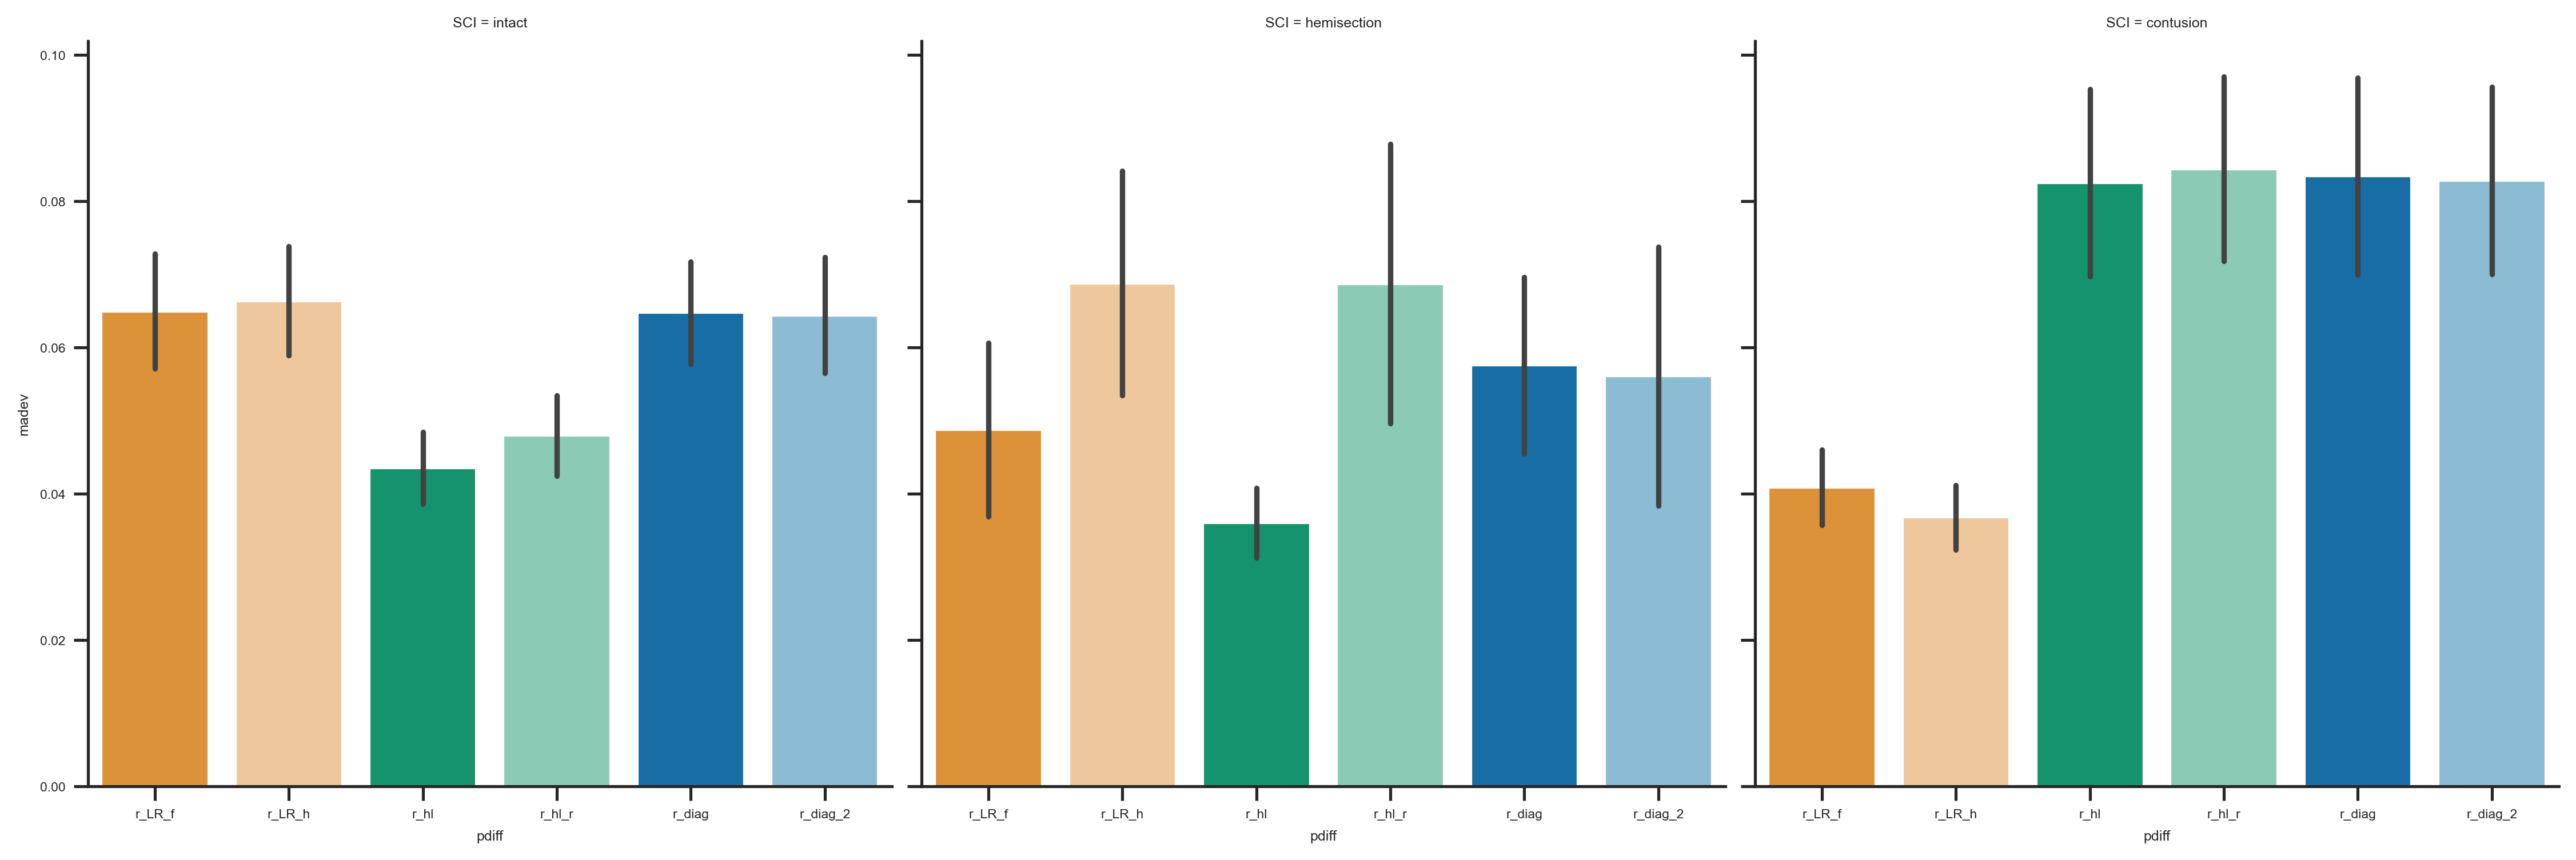

In [98]:
def ma_circ(x,fc,interval=1):
    """Calculates moving average of x (in radians) with normalized cutoff frequency fc"""
    alpha = (fc*2*np.pi*interval)/(fc*2*np.pi*interval+1)
    y=np.zeros(len(x))
    y[0]=x[0]
    for i in range(1,len(x)):
        y[i] = y[i-1]+alpha*(np.angle(np.exp(1j*x[i])/np.exp(1j*y[i-1])))
    y=y%(2*np.pi)
    return y

def ma_dev(x,fc,interval=1):
    """Calculates mean deviation of x (in radians) from its moving average with normalized cutoff frequency fc"""
    ma_x = ma_circ(x,fc,interval)
    return np.mean(np.abs(np.angle(np.exp(1j*(x-ma_x)))))/(np.pi)

def calc_mean_ma_dev(df_,fc):
    """Calculates mean deviation from the moving average for all six phase differences in dataframe df_ with normalized cutoff frequency fc"""
    ret={}
    for phase_diff in ['LR_h','hl','diag','LR_f','hl_r','diag_2']:
        ret['r_'+phase_diff]=ma_dev(df_[phase_diff].values*np.pi*2.0,fc)
    return ret

df_phases = df_phases_simulation
# mean deviations from the moving average of each phase difference for each bout
res_=df_phases.groupby(['SCI','ID','RID','bout']).apply(lambda df:calc_mean_ma_dev(df,0.125)).apply(pd.Series)
res=res_.reset_index()
df_madev=res.melt(id_vars=['SCI','ID','RID','bout'], var_name='pdiff',value_name='madev')
print(df_madev)
df_madev.SCI=pd.Categorical(df_madev.SCI,categories=['intact','hemisection','contusion'])
df_madev.pdiff=pd.Categorical(df_madev.pdiff,categories=['r_LR_f', 'r_LR_h',  'r_hl', 'r_hl_r','r_diag', 'r_diag_2'])
print(df_madev)
df_madev.iteritems = df_madev.items;

cp_ = ['#F7941D','#FBC98F','#00A875','#80D4B8','#0072BC','#80BFE0']


sns.catplot(data=df_madev, x='pdiff', y='madev', col='SCI',kind='bar',ci='sd',ax=ax, palette=cp_)
sns.despine()


## Figure 7B: hemisection gaits

### B1 model

trot      	LR=0.611+-0.052, HL=0.520+-0.034, diag=0.997+-0.052
canter    	LR=0.713+-0.046, HL=0.513+-0.036, diag=0.977+-0.050
trans_1   	LR=0.762+-0.063, HL=0.584+-0.034, diag=0.095+-0.049


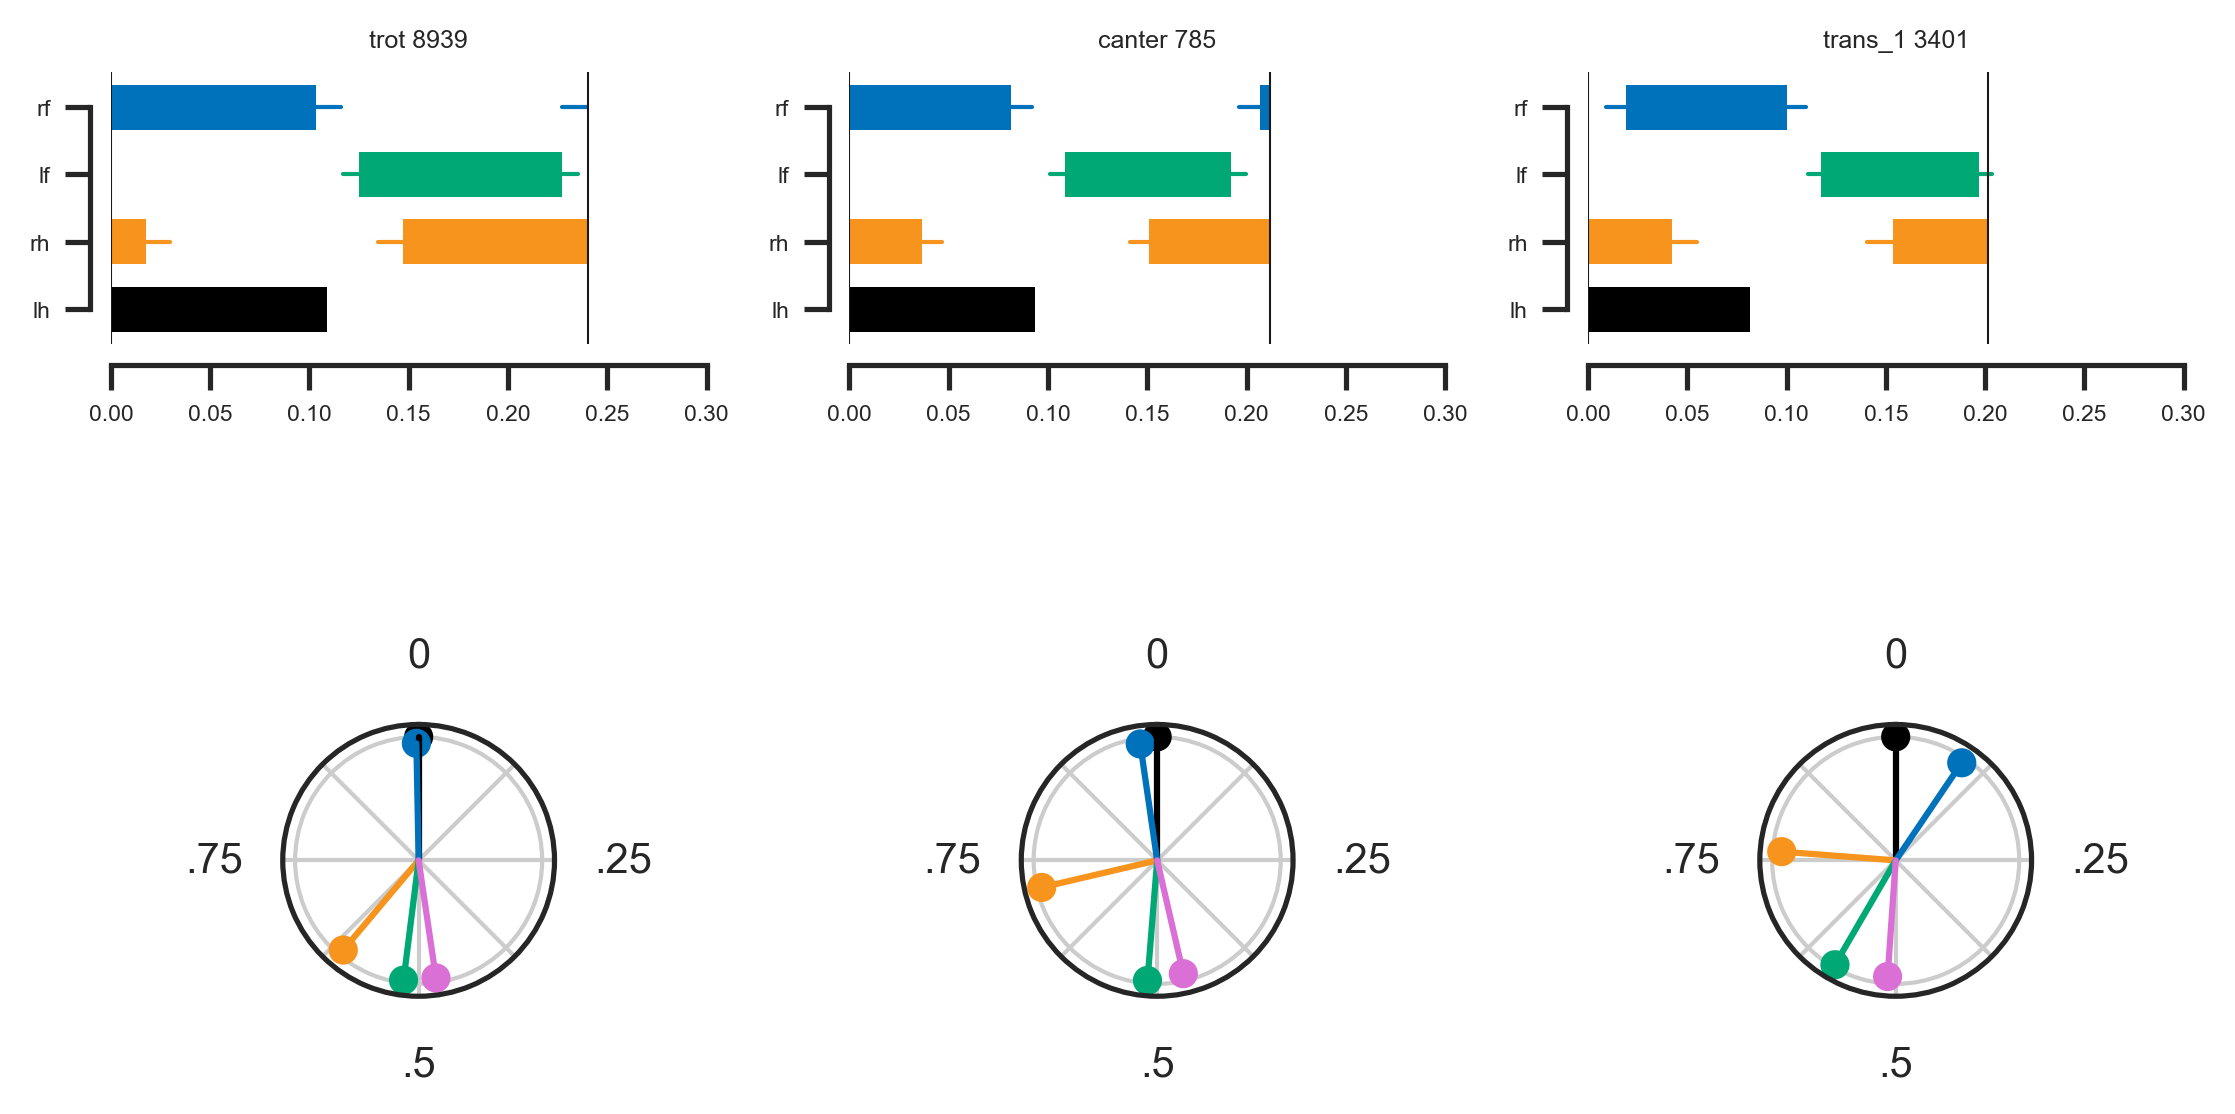

In [102]:
fig = plot_gait_properties(df_phases_simulation,'hemisection', ['trot','canter','trans_1'])

### B2 rats

trot      	LR=0.529+-0.075, HL=0.471+-0.047, diag=0.014+-0.073
canter    	LR=0.678+-0.074, HL=0.432+-0.050, diag=0.021+-0.054
trans_1   	LR=0.764+-0.072, HL=0.537+-0.056, diag=0.164+-0.062


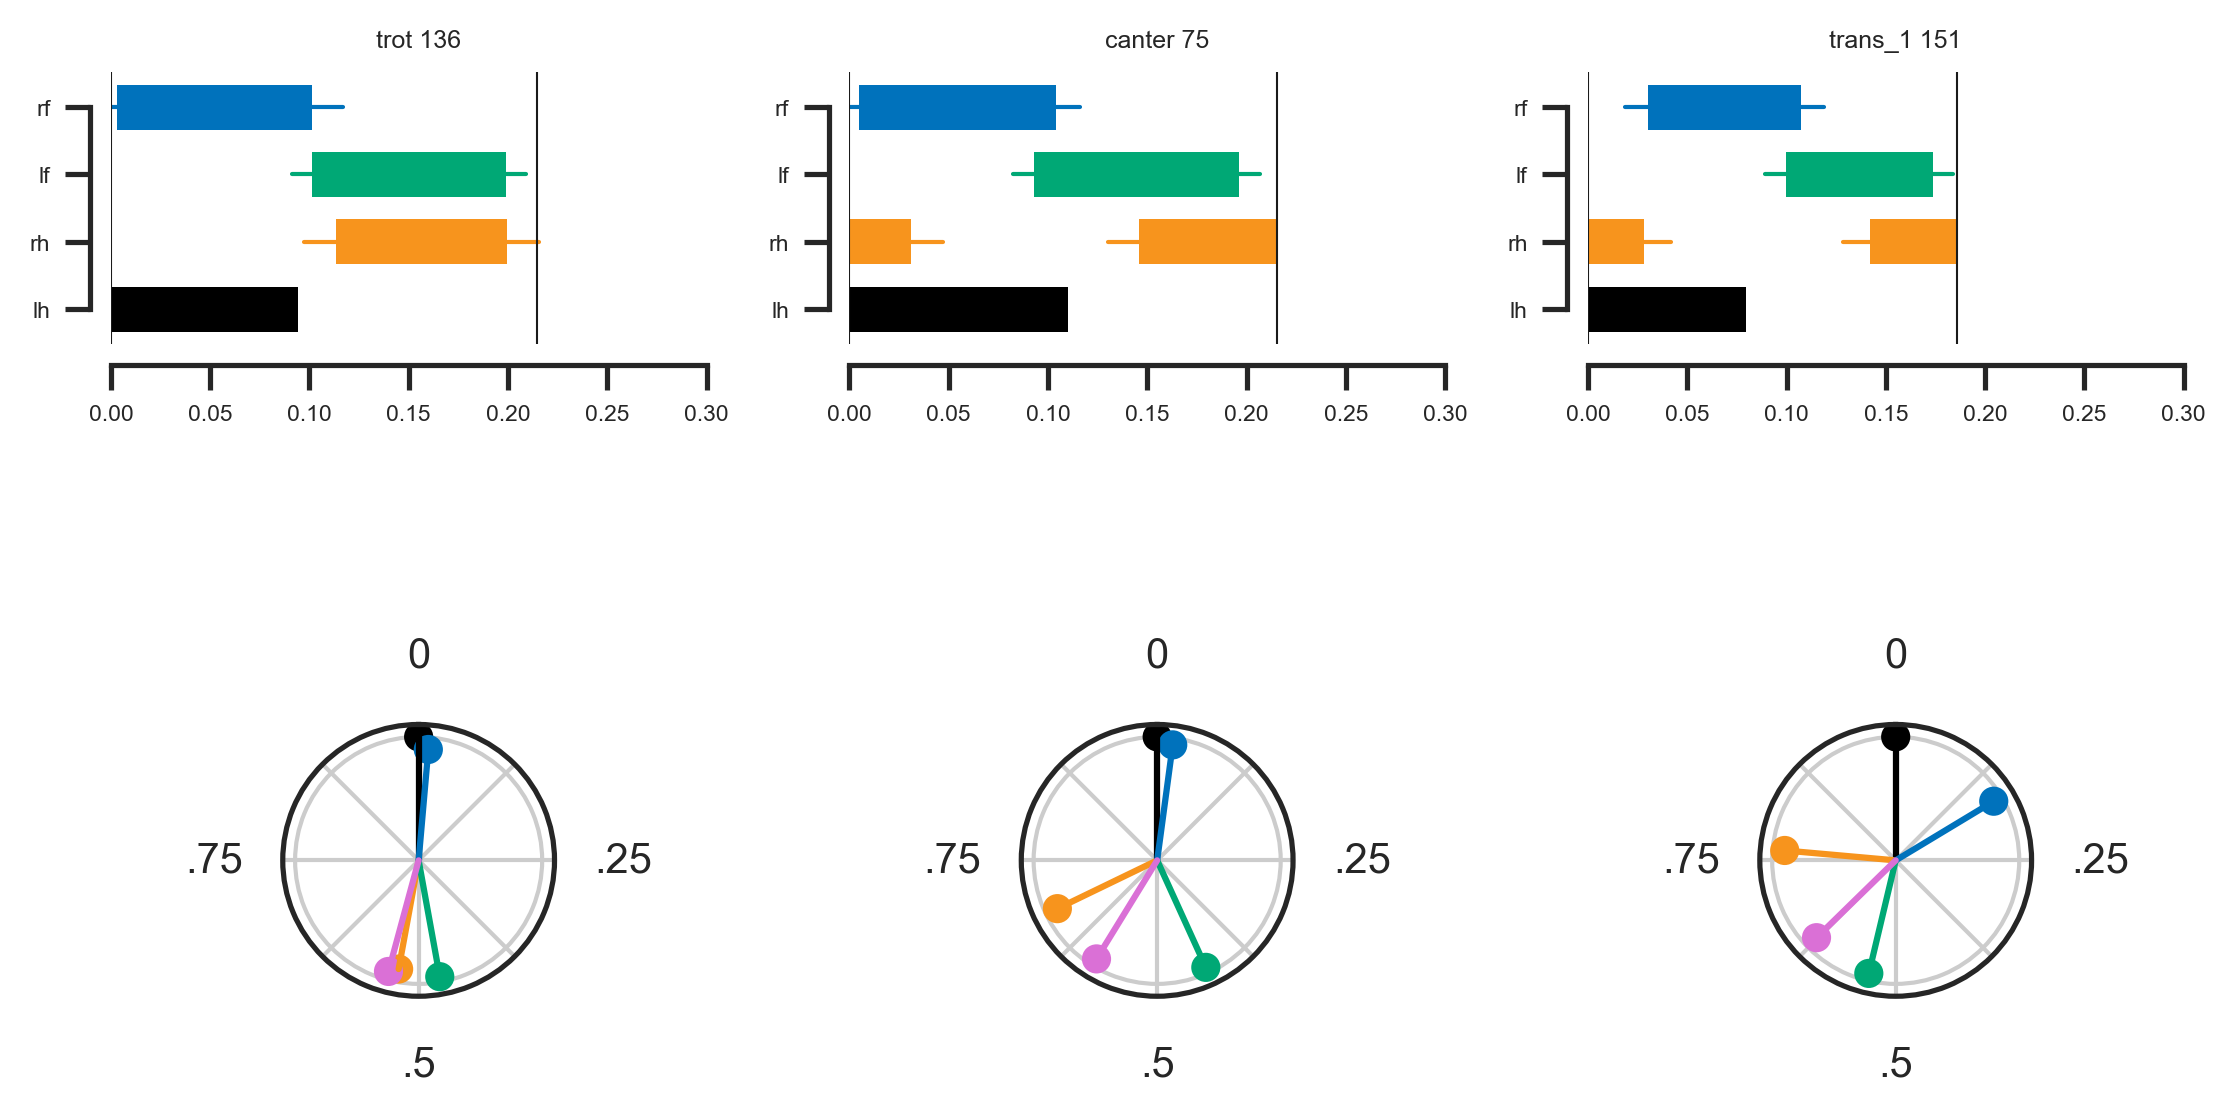

In [101]:
fig = plot_gait_properties(df_phases_data,'hemisection', ['trot','canter','trans_1'])

## Figure 7C: lead limb preference

In [ ]:
def plot_lead_limb_preference(df_phases):
    
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(6, 1.5, forward=True)

    df_=df_phases[(df_phases.SCI!='contusion')&(df_phases.gaits_all2.isin(['trans_1','trans_2','canter','canter_2']))]
    df_.loc[df_.gaits_all2.isin(['canter','trans_1']),'lead_limb']='contralesional'
    df_.loc[df_.gaits_all2.isin(['canter_2','trans_2']),'lead_limb']='ipsilesional'
    ct = pd.crosstab(df_.lead_limb, df_.SCI,dropna=True,normalize='columns')

    print('proportion')
    print(ct)
    print('\n\ncounts')
    print(pd.crosstab(df_.lead_limb, df_.SCI,dropna=True))
    stacked = ct.stack().reset_index().rename(columns={0: 'value'})


    stacked = stacked.rename(index=str, columns={'value': 'occurance'})
    stacked.occurance = stacked.occurance*100
    pivot_df = stacked.pivot(index='SCI', columns='lead_limb', values='occurance')
    pivot_df.plot.barh(stacked=True,ax=ax,lw=0)
    ax.set_ylabel('left-right asymmetric gaits')
    or_,pval = scstats.fisher_exact(pd.crosstab(df_.lead_limb, df_.SCI,dropna=True))
    print("Fisher's exact test: OR = {:2.3f}, p = {:2.4f}".format(or_,pval))
    print('\n')
    sns.despine(offset=2,trim=True)

    ax.tick_params(labelbottom=False)
    ax.set_xlabel('Proportion (%)')


### C1 lead-limb preference model

proportion
SCI             intact  hemisection
lead_limb                          
contralesional  0.4588     0.959652
ipsilesional    0.5412     0.040348


counts
SCI             intact  hemisection
lead_limb                          
contralesional    2088         4186
ipsilesional      2463          176
Fisher's exact test: OR = 0.036, p = 0.0000




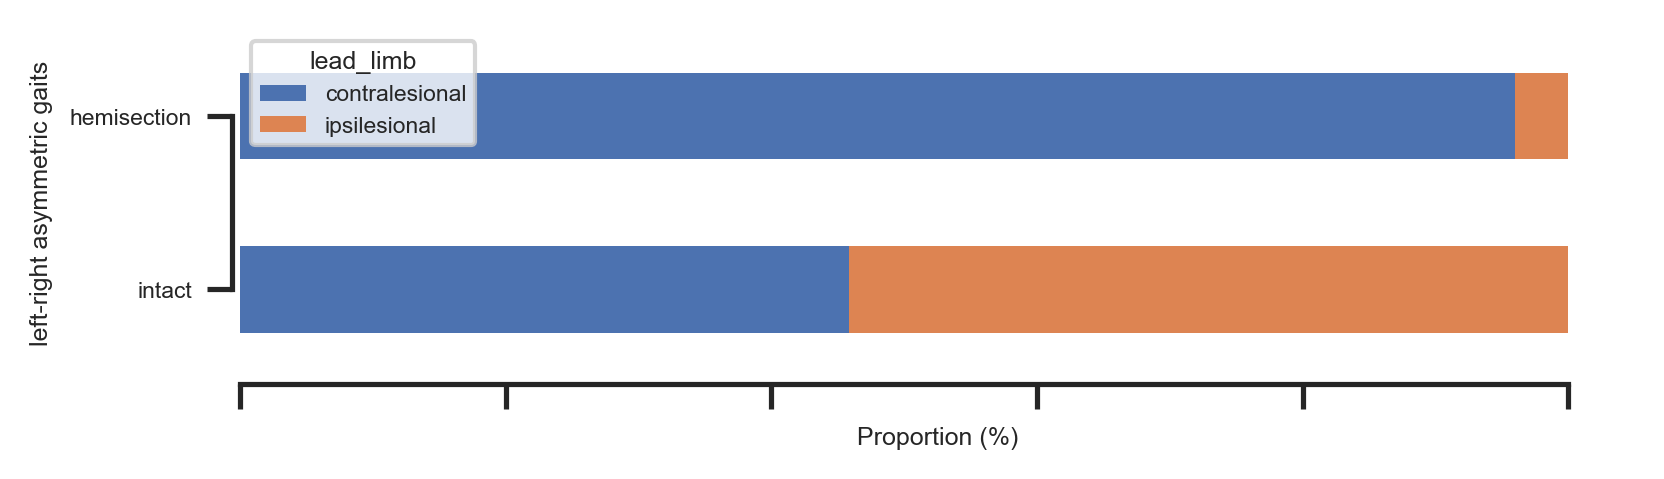

In [113]:
plot_lead_limb_preference(df_phases_simulation)

### C2 lead-limb preference rats

proportion
SCI               intact  hemisection
lead_limb                            
contralesional  0.359413     0.976096
ipsilesional    0.640587     0.023904


counts
SCI             intact  hemisection
lead_limb                          
contralesional     147          245
ipsilesional       262            6
Fisher's exact test: OR = 0.014, p = 0.0000




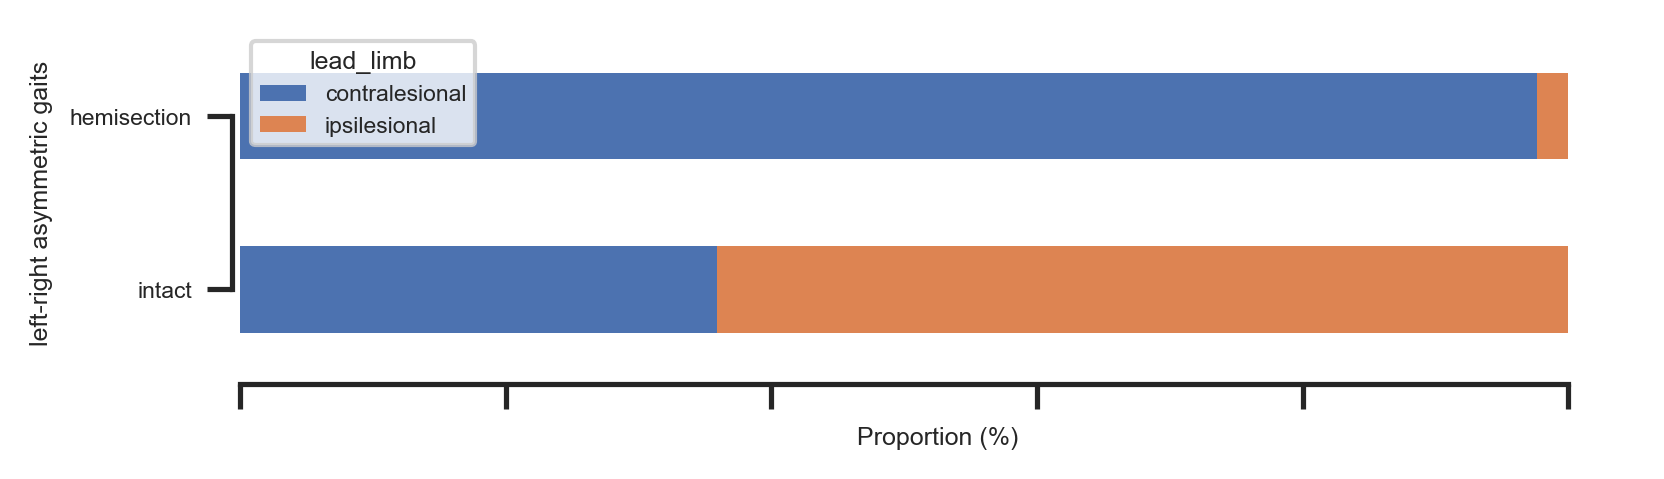

In [114]:
plot_lead_limb_preference(df_phases_data)

# Figure 8: Frequency-dependent distribution of normalized phase differences and gaits - hemisection

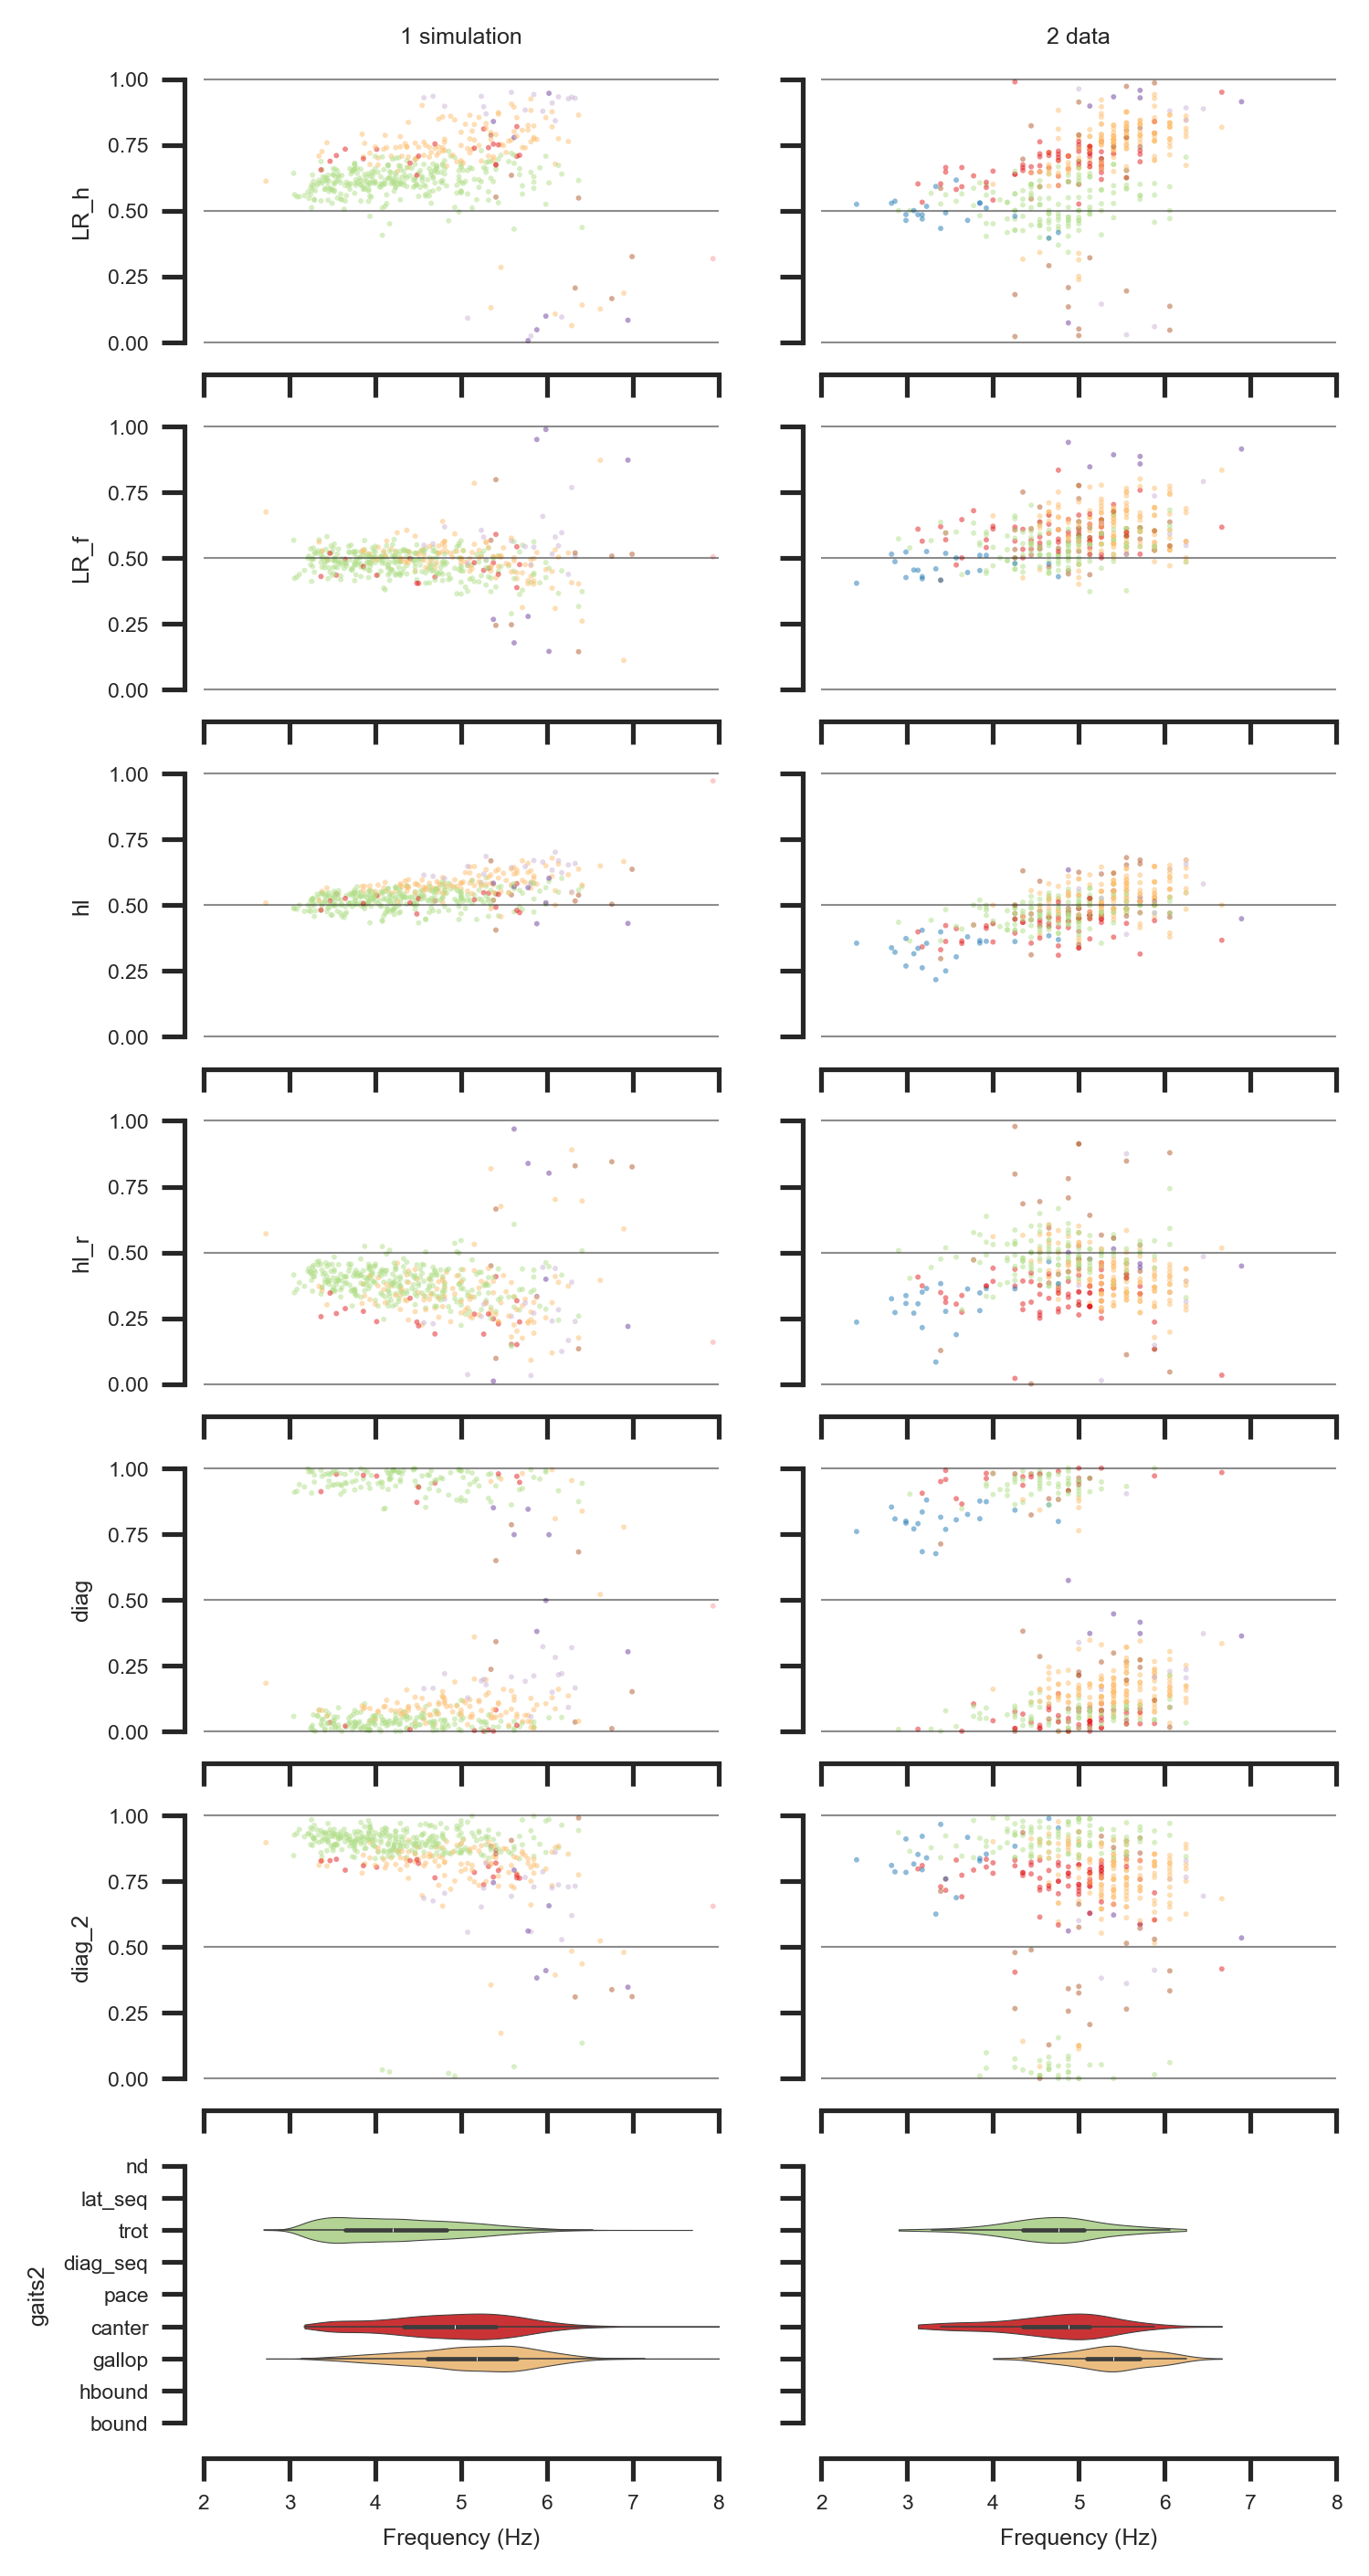

In [123]:
plot_phase_frequency_distribution('hemisection')

# Figure 9 - Bifurcation diagrams
See "bifurcation_diagrams.ipynb"

# Figure 11 - Gait expression - contusion

### 11B1 - model

trot      	LR=0.500+-0.043, HL=0.514+-0.072, diag=0.025+-0.073
pace      	LR=0.497+-0.050, HL=0.019+-0.077, diag=0.499+-0.071
lat_seq   	LR=0.497+-0.048, HL=0.270+-0.074, diag=0.764+-0.075
diag_seq  	LR=0.504+-0.040, HL=0.713+-0.070, diag=0.218+-0.070


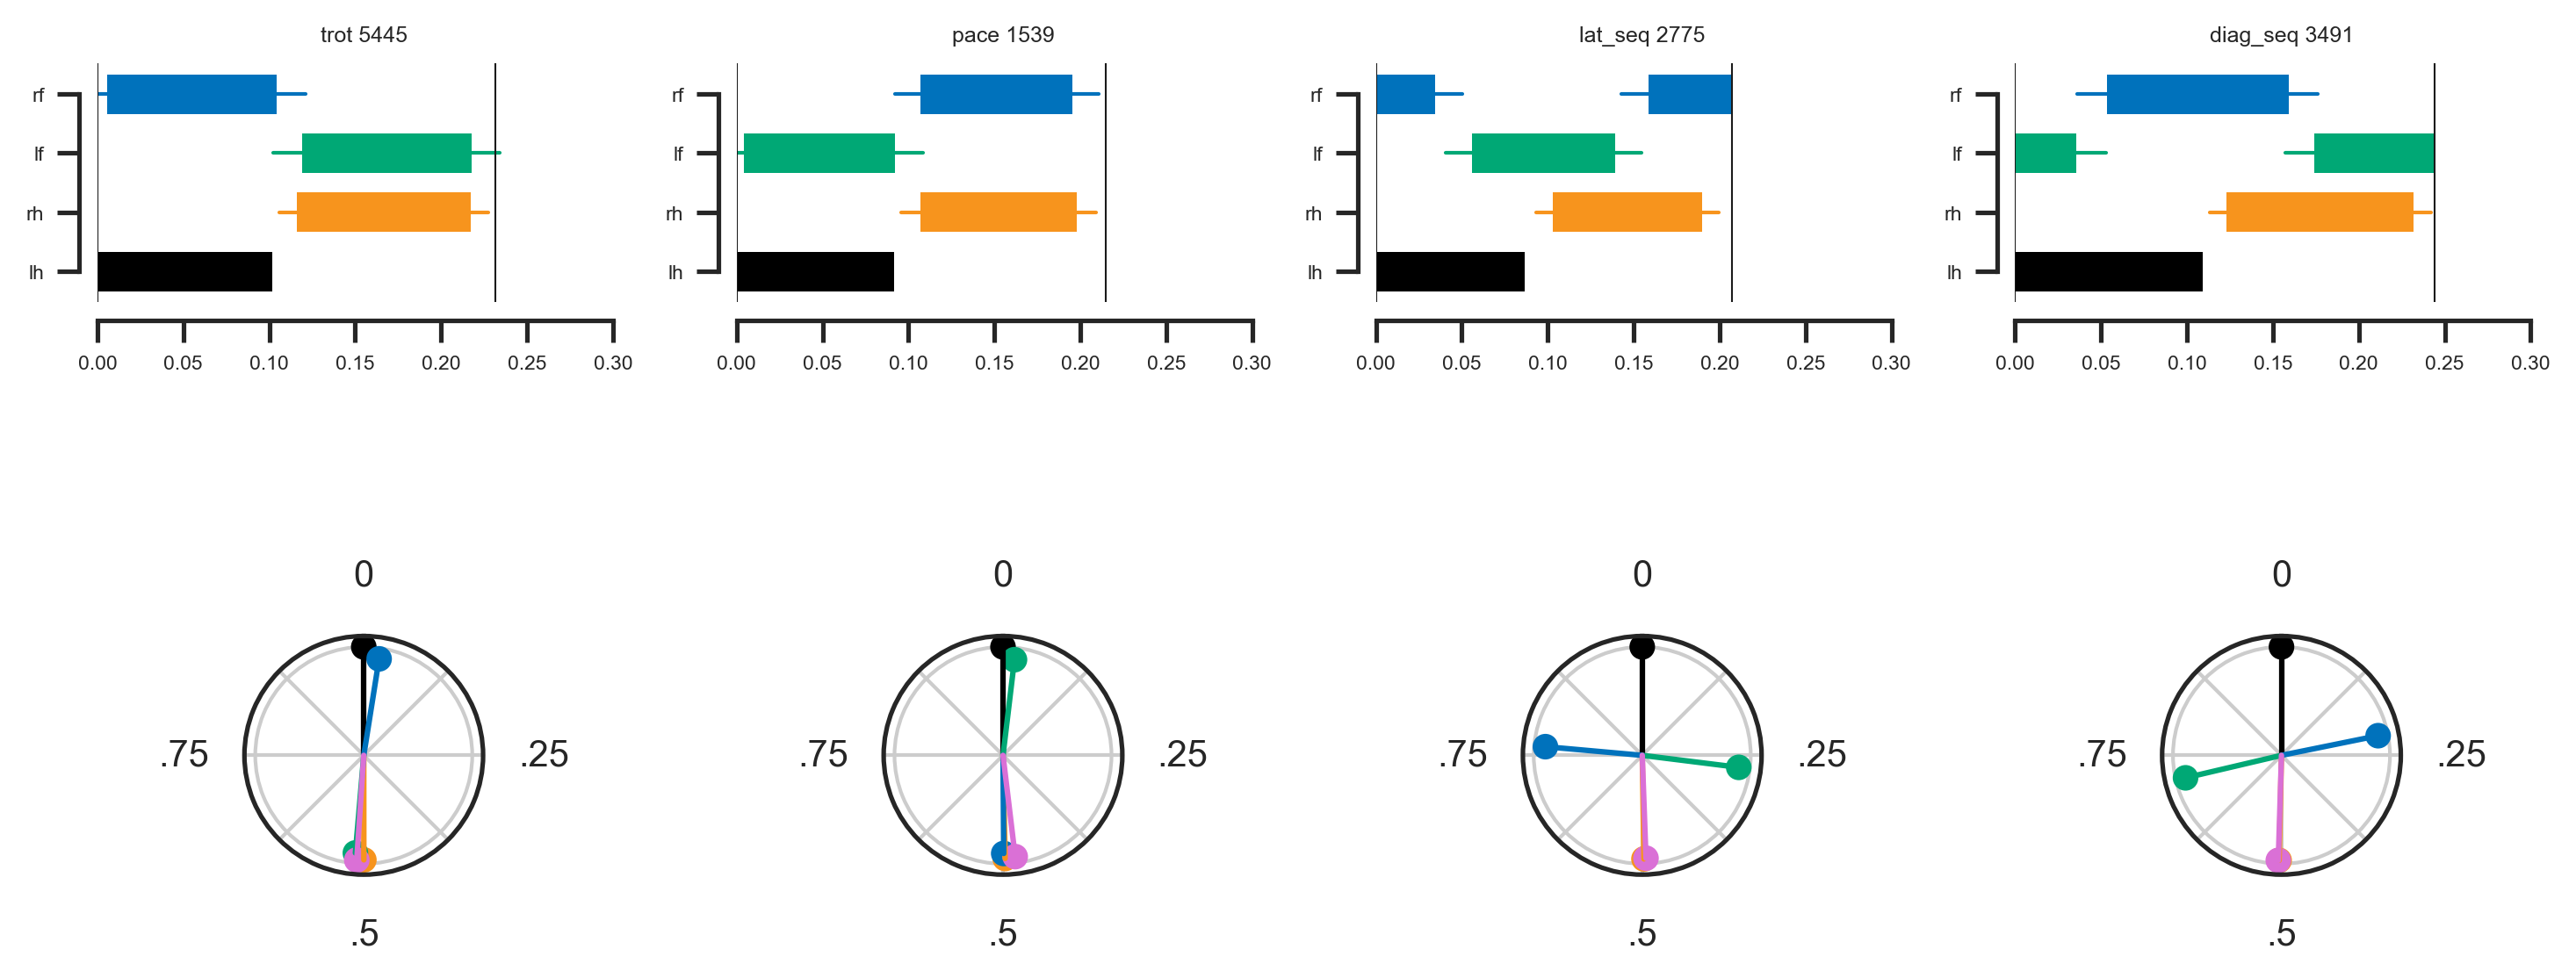

In [129]:
fig = plot_gait_properties(df_phases_simulation,'contusion', ['trot','pace','lat_seq','diag_seq'],'gaits2')

### 11B2 - rats

trot      	LR=0.513+-0.058, HL=0.480+-0.057, diag=0.993+-0.070
pace      	LR=0.483+-0.091, HL=0.036+-0.074, diag=0.483+-0.071
lat_seq   	LR=0.476+-0.040, HL=0.283+-0.078, diag=0.762+-0.084
diag_seq  	LR=0.488+-0.067, HL=0.714+-0.079, diag=0.239+-0.079


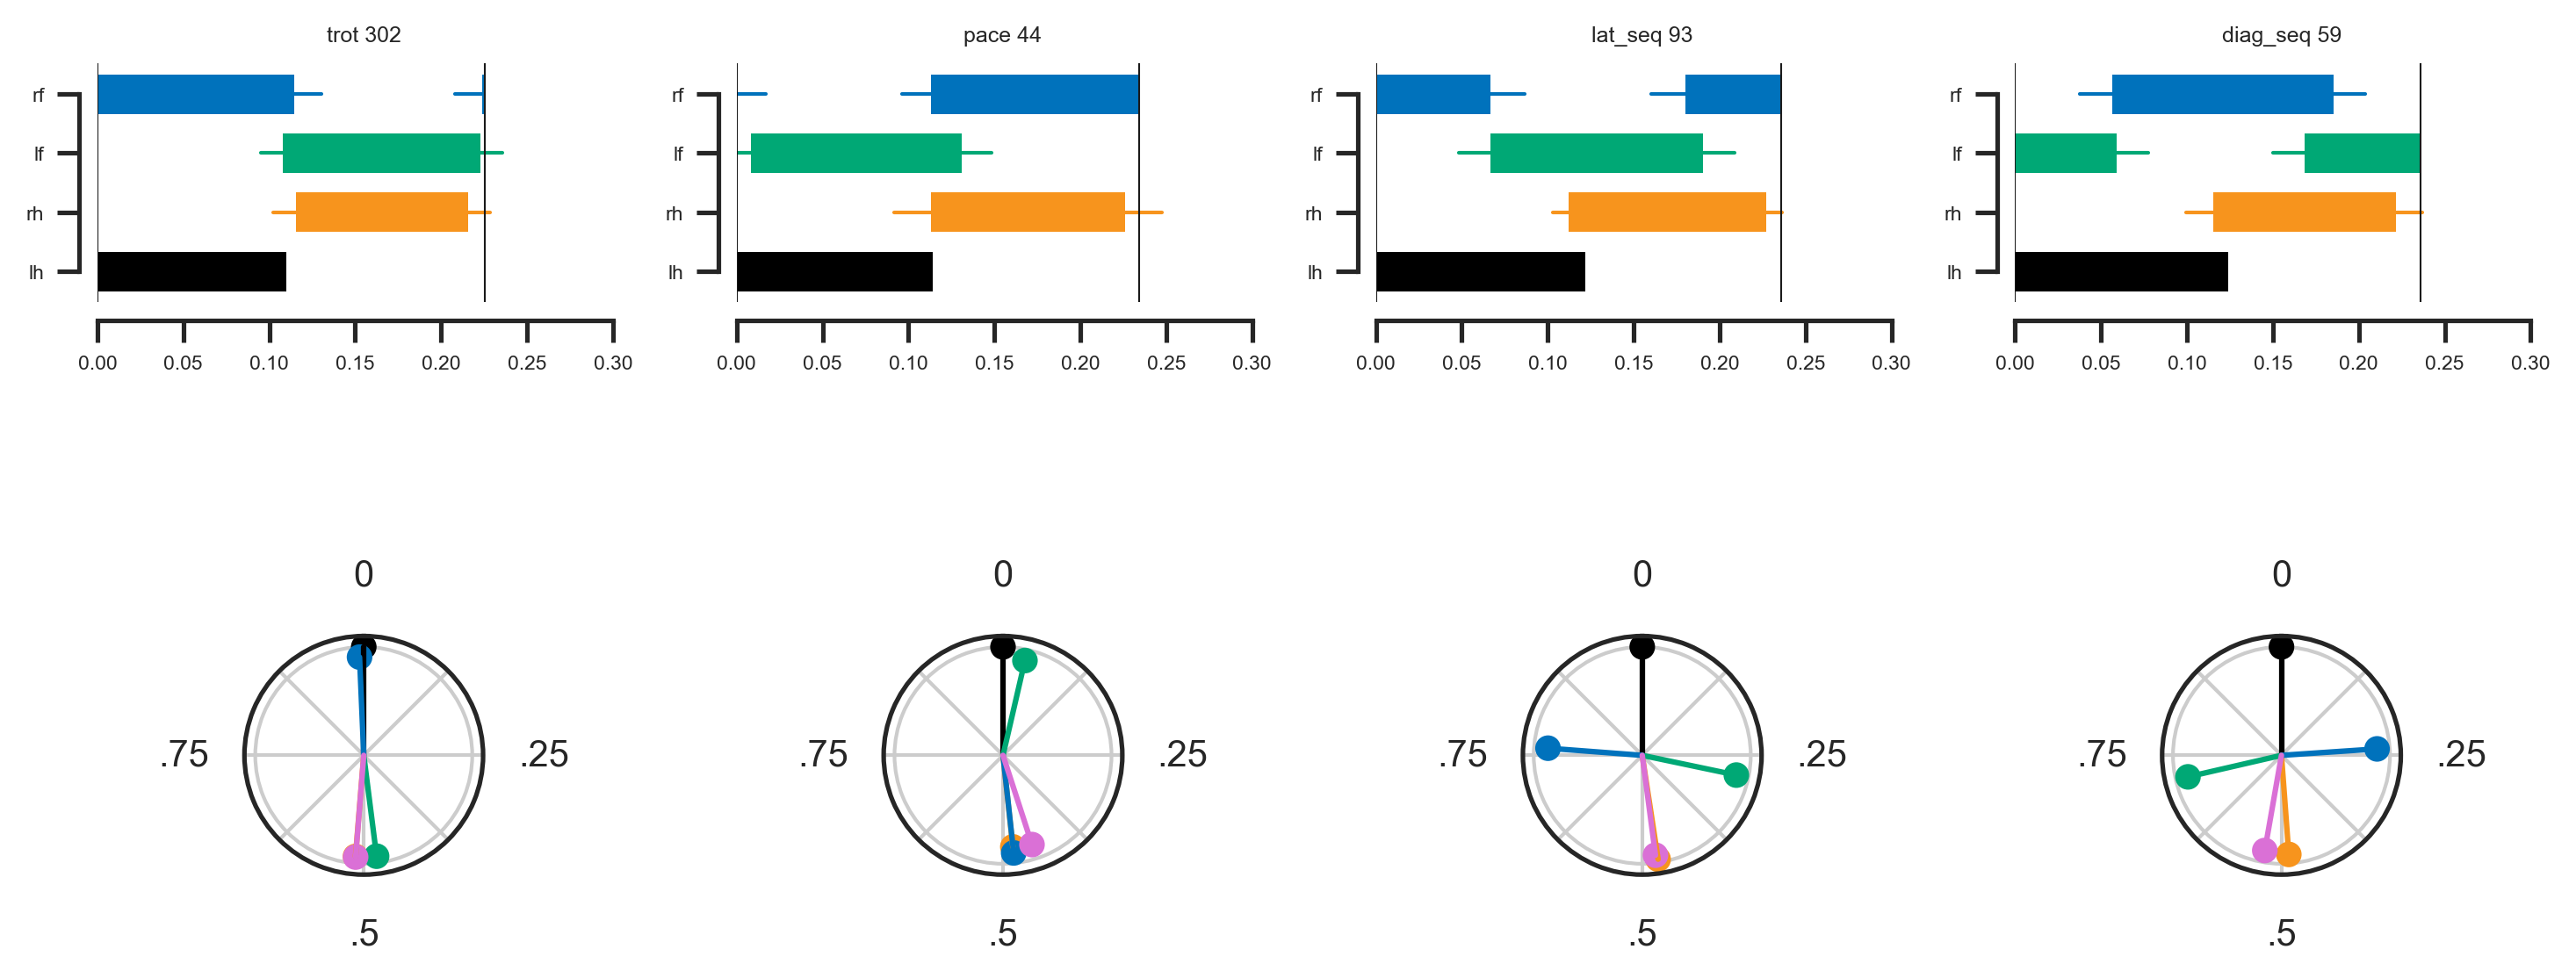

In [130]:
fig = plot_gait_properties(df_phases_data,'contusion', ['trot','pace','lat_seq','diag_seq'],'gaits2')

# Figure 12 - Frequency-dependent distribution of normalized phase-differences and gaits - contusion injury

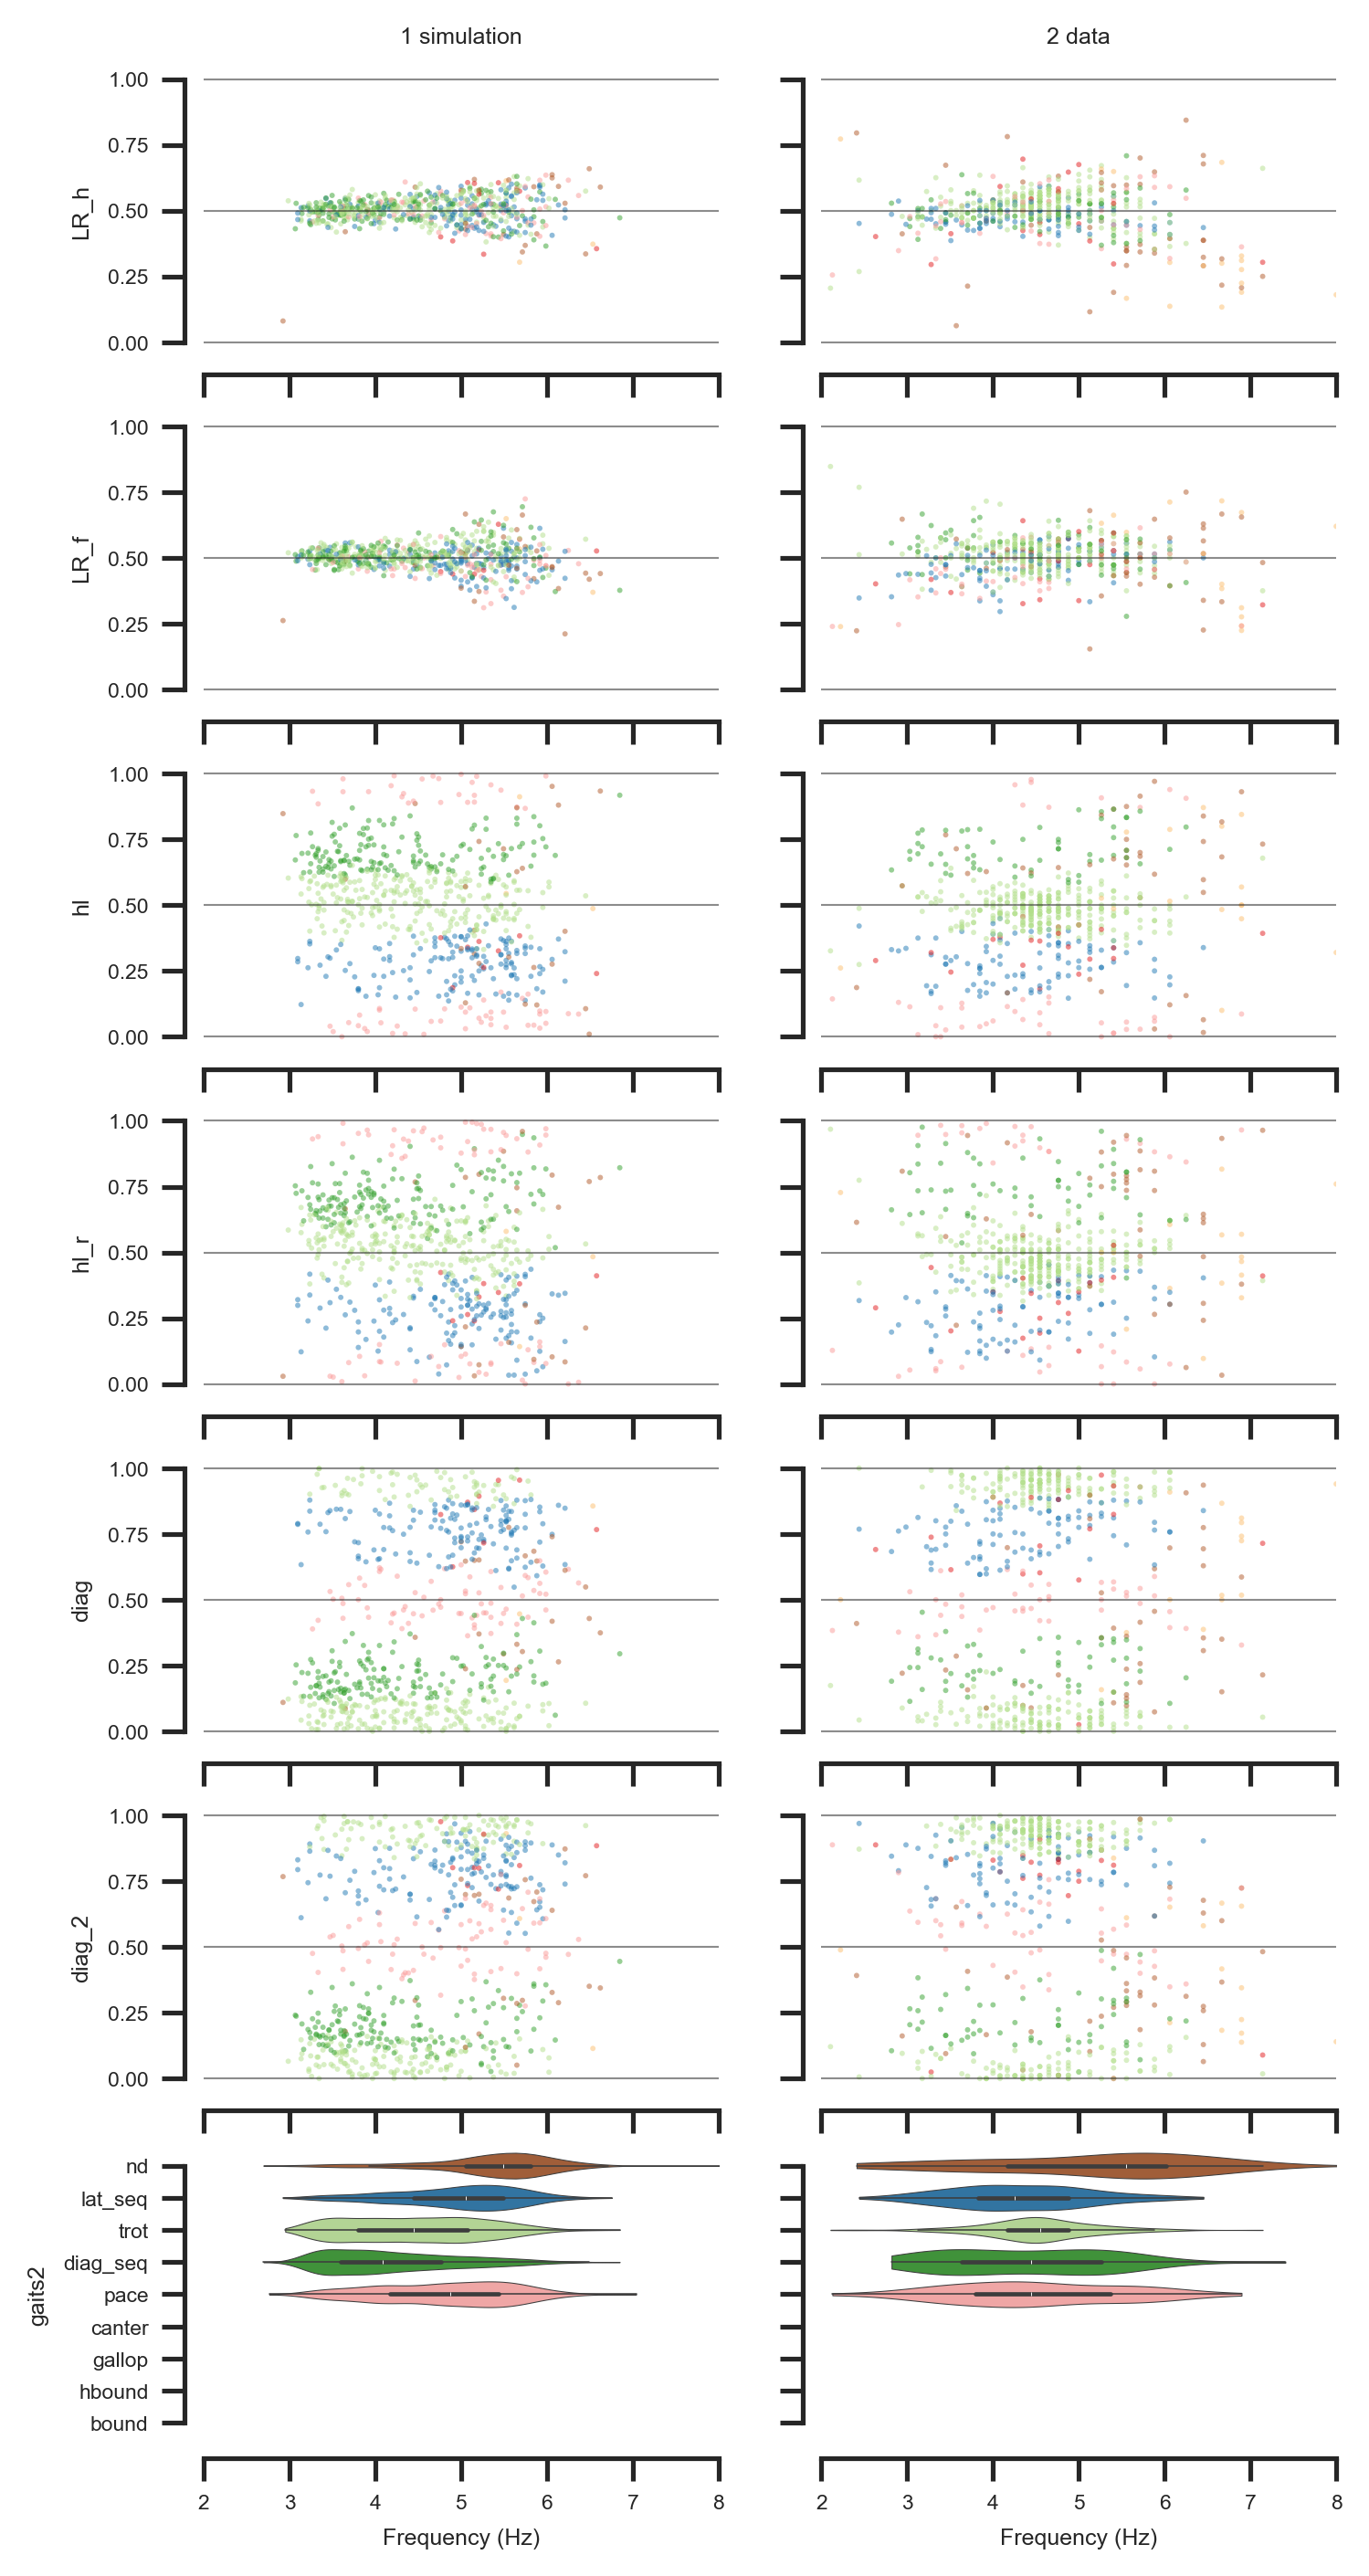

In [131]:
plot_phase_frequency_distribution('contusion')